In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os,sys, gc
import keras


dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from pre_process import clean_LC,generate_representation
from evaluation import calculate_metrics, evaluate_metadata, evaluate_metadata_raw


folder = "../../KOI_Data/"
folder_lc = "/work/work_teamEXOPLANET/KOI_LC/"

Using TensorFlow backend.


In [2]:
def impute_on_pandas(df):
    return df.fillna(df.median(),inplace=False)

df_meta = pd.read_csv(folder+"/kepler_dataset.csv")
all_labels = df_meta["NExScI Disposition"].values
mask_conf = (all_labels=="CONFIRMED")
mask_fp = (all_labels=="FALSE POSITIVE")
mask_cand = (all_labels=="CANDIDATE")

#NEW METADATA SELECTED!
metadata_used = ["Period", "Duration", "Time of Transit Epoch", "r/R", "a/R",
                 "Inclination", "Impact Parameter", 
                 "Fitted Stellar Density",
                 "Teq",
                 "Limb Darkening Coeff1", "Limb Darkening Coeff2",
                "Teff","Stellar Radius", "Stellar Mass"]
#dividir duration por 24??
df_meta["Duration"] = df_meta["Duration"]/24

#df_meta["Time of Transit Epoch"] = df_meta["Time of Transit Epoch"]- time_kepler[:,0] #modificacion

df_meta_obj = df_meta[metadata_used]
mask_nan = pd.isna(df_meta_obj)

df_meta_obj = impute_on_pandas(df_meta_obj)

df_meta_obj.head()

Period  Duration  Time of Transit Epoch    r/R      a/R  Inclination  \
0    8.884923  0.086252             169.991686  0.114   36.466        89.89   
1    5.092465  0.152458             357.535940  0.014   10.670        89.14   
2  275.073650  0.140417             315.248600  0.014  512.000        89.93   
3    8.460439  0.197288             133.774490  0.478   14.087        85.68   
4   21.761298  0.051792             166.540438  0.032  137.070        89.95   

   Impact Parameter  Fitted Stellar Density    Teq  Limb Darkening Coeff1  \
0             0.069                11.62061  770.0                  0.497   
1             0.161                 0.88510  844.0                  0.551   
2             0.595                33.55994  303.0                  0.437   
3             1.061                 0.73874  804.0                  0.299   
4             0.123               102.86534  486.0                  0.627   

   Limb Darkening Coeff2    Teff  Stellar Radius  Stellar Mass  
0                  0.204  5332.0           0.843         0.821  
1                  0.165  5037.0           0.751         0.727  
2                  0.243  5604.0           1.187         0.864  
3                  0.306  5951.0           0.702         0.796  
4                  0.108  4859.0           0.720         0.781

In [3]:
df_sets = pd.read_csv(folder+"/koi_sets.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values

mask_train_conf = mask_train & mask_conf
mask_test_conf = mask_test & mask_conf

In [4]:
Y_train = df_meta_obj.values[mask_train_conf]
Y_test = df_meta_obj.values[mask_test_conf]
Y_train.shape

(1610, 14)

In [5]:
#pre-process: scale metadata
from sklearn.preprocessing import StandardScaler, RobustScaler
#scaler_meta = RobustScaler()
scaler_meta = StandardScaler()

Ystd_train = scaler_meta.fit_transform(Y_train)
Ystd_test = scaler_meta.transform(Y_test)

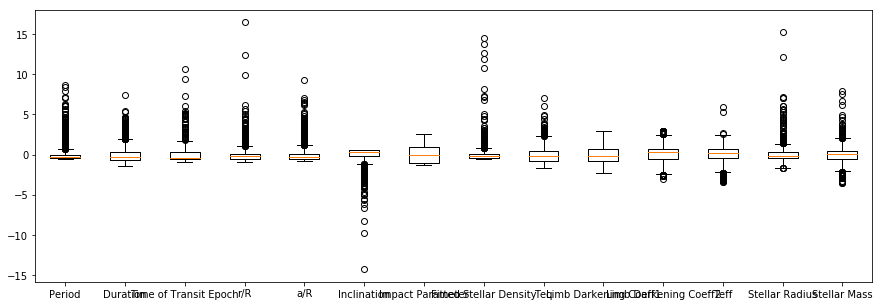

Period      Duration  Time of Transit Epoch           r/R  \
count  1.610000e+03  1.610000e+03           1.610000e+03  1.610000e+03   
mean  -6.619963e-17  7.833623e-16           5.957967e-15 -1.624649e-15   
std    1.000311e+00  1.000311e+00           1.000311e+00  1.000311e+00   
min   -5.908227e-01 -1.450501e+00          -8.906004e-01 -8.851677e-01   
25%   -4.821600e-01 -6.703882e-01          -5.516610e-01 -5.040630e-01   
50%   -3.365976e-01 -2.669818e-01          -4.050554e-01 -2.076482e-01   
75%   -1.750069e-03  3.716218e-01           3.663228e-01  1.311116e-01   
max    8.616681e+00  7.401561e+00           1.070401e+01  1.647627e+01   

                a/R   Inclination  Impact Parameter  Fitted Stellar Density  \
count  1.610000e+03  1.610000e+03      1.610000e+03            1.610000e+03   
mean   1.518178e-15 -6.771119e-14      1.331716e-15            6.024167e-16   
std    1.000311e+00  1.000311e+00      1.000311e+00            1.000311e+00   
min   -8.407552e-01 -1.431460e+01     -1.305204e+00           -5.335584e-01   
25%   -5.662212e-01 -1.426957e-01     -1.045922e+00           -4.219073e-01   
50%   -3.274285e-01  3.226130e-01     -8.717967e-02           -2.298973e-01   
75%    1.281076e-01  5.689991e-01      9.582414e-01            8.804824e-02   
max    9.296306e+00  6.317726e-01      2.614182e+00            1.447999e+01   

                Teq  Limb Darkening Coeff1  Limb Darkening Coeff2  \
count  1.610000e+03           1.610000e+03           1.610000e+03   
mean  -2.427320e-17          -2.641365e-15           2.371823e-14   
std    1.000311e+00           1.000311e+00           1.000311e+00   
min   -1.728111e+00          -2.258535e+00          -3.089904e+00   
25%   -7.441942e-01          -8.013483e-01          -5.591437e-01   
50%   -1.479202e-01          -1.761280e-01           2.596318e-01   
75%    4.921406e-01           7.206023e-01           7.062367e-01   
max    7.011231e+00           2.932537e+00           2.983921e+00   

               Teff  Stellar Radius  Stellar Mass  
count  1.610000e+03    1.610000e+03  1.610000e+03  
mean   2.250788e-16   -2.257408e-15  3.208476e-15  
std    1.000311e+00    1.000311e+00  1.000311e+00  
min   -3.395382e+00   -1.703084e+00 -3.525412e+00  
25%   -4.824721e-01   -4.884028e-01 -5.372881e-01  
50%    1.926621e-01   -1.801033e-01  9.894913e-03  
75%    6.795483e-01    2.726248e-01  5.044431e-01  
max    5.973887e+00    1.529320e+01  7.896348e+00

In [6]:
### boxplot de las variables..
plt.figure(figsize=(15,5))
plt.boxplot(Ystd_train)
plt.xticks(np.arange(len(metadata_used))+1,metadata_used)
plt.show()
aux_df = pd.DataFrame(Ystd_train)
aux_df.columns = metadata_used
aux_df.describe()

In [7]:
### evaluar.. residuo + errores .
def get_res(x,xhat):
    x = np.squeeze(x)
    xhat = np.squeeze(xhat)
    return x - xhat

def RMSE_LC(x, xhat, res=[]):
    if len(res) == 0:
        res = get_res(x, xhat)
    return np.mean( np.sqrt(np.mean(np.square(res), axis=-1)) )

def MSE_LC(x, xhat, res=[]):
    if len(res) == 0:
        res = get_res(x, xhat)
    return np.mean(np.mean( np.square(res), axis=-1))

def MAE_LC(x, xhat, res=[]):
    if len(res) == 0:
        res = get_res(x, xhat)
    return np.mean( np.mean( np.abs(res), axis=-1))

def evaluate_reconst(x,xhat):
    print("----- EVALUANDO RECONSTRUCCION DE LA CURVA -----")
    res = get_res(x, xhat)
    plt.figure(figsize=(8,5))
    sns.distplot(res.flatten())
    plt.title("Distribucion de residuos promedio")
    plt.show()
    
    print("MSE      = ",MSE_LC(None,None, res))
    print("RMSE (+-)= ",RMSE_LC(None,None, res))
    print("MAE  (+-)= ",MAE_LC(None,None, res))
    
    print("--------- Smoothness ------------")
    xhat = np.squeeze(xhat)
    A = np.mean(np.apply_along_axis(autocorr_func, 1, xhat)[:,1])
    print("AutoCorr lag-one = ",A)
    M = np.mean(np.apply_along_axis(mean_diff, 1, xhat))
    print("Diff MEAN = ",M)
    S = np.mean(np.apply_along_axis(std_diff, 1, xhat))
    print("Diff STD = ",S)
    print("--------- Smoothness ------------")
        
#https://en.wikipedia.org/wiki/Autocorrelation
#https://stats.stackexchange.com/questions/24607/how-to-measure-smoothness-of-a-time-series-in-r
def autocorr_func(x):
    #FATS: https://arxiv.org/pdf/1506.00010.pdf
    if np.sum(x) == 0:
        return 0
    inp = x - np.mean(x)
    result = np.correlate(inp, inp, mode='full')
    return result[len(x)-1:]/np.var(x, ddof=len(x)-1)

#:::::::lag-one autocorrelation
# scores near 1 imply a smoothly varying series
# scores near 0 imply that there's no overall linear relationship between a data point and the following one (that is, plot(x[-length(x)],x[-1]) won't give a scatterplot with any apparent linearity)
# scores near -1 suggest that the series is jagged in a particular way: if one point is above the mean, the next is likely to be below the mean by about the same amount, and vice
def std_diff(x):
    if np.sum(x) == 0:
        return 0
    aux = np.abs(np.diff(x, axis=-1))
    return np.std(aux)#/np.mean(aux)

def mean_diff(x):
    if np.sum(x) == 0:
        return 0
    aux = np.abs(np.diff(x, axis=-1))
    return np.mean(aux)#/np.mean(aux)

### Create dataset

In [8]:
mask_transit = np.load("data/mask_transit_LC.npy")  #
# datos de abajo debieran ser todas las curvas.. poner mascara sobre los utilziados
mask_transit

array([ True,  True, False, ...,  True,  True,  True])

In [9]:
T = 300
X_fold_lc = np.load("data/LC_global_%dT.npy"%T)
X_fold_lc_aug = np.load("data/LC_globalA_%dT.npy"%T)
X_fold_time = np.load("data/Time_global_%dT.npy"%T)
X_fold_lc.shape

(8054, 300)

In [10]:
## NEW : set mask
X_fold_lc_tr = X_fold_lc[mask_transit]
X_fold_lc_aug_tr = X_fold_lc_aug[mask_transit]
X_fold_time_tr = X_fold_time[mask_transit]
N,T = X_fold_lc_tr.shape

In [11]:
mask_train = np.random.rand(X_fold_lc_tr.shape[0])< 1#0.75
mask_test = ~mask_train

In [12]:
#X_train = np.concatenate([X_fold_lc[mask_train[mask_conf]], X_fold_lc_aug[mask_train[mask_conf]]], axis=0)
X_train_t = np.concatenate([X_fold_time_tr[mask_train], X_fold_time_tr[mask_train]], axis=0)
#X_train = np.concatenate([X_fold_lc[mask_train[mask_conf]], X_fold_lc_aug[mask_train[mask_conf]]], axis=0)
X_train = np.concatenate([X_fold_lc_tr[mask_train], X_fold_lc_aug_tr[mask_train]], axis=0)

if Ystd_train.shape[0] != X_train.shape[0]:
    Ystd_train = np.tile(Ystd_train, (2,1))

#X_test = X_fold_lc[mask_test[mask_conf]]
X_test = X_fold_lc_tr[mask_test]
#X_test_t = X_fold_time[mask_test[mask_conf]]
X_test_t = X_fold_time_tr[mask_test]

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

X_train_t = np.expand_dims(X_train_t, axis=-1)
X_test_t = np.expand_dims(X_test_t, axis=-1)

print("X train shape: ",X_train.shape)
print("X train time shape: ",X_train_t.shape)
print("X test shape: ",X_test.shape)
print("Y train shape: ",Ystd_train.shape)
print("Y test shape: ",Ystd_test.shape)

X train shape:  (8634, 300, 1)
X train time shape:  (8634, 300, 1)
X test shape:  (0, 300, 1)
Y train shape:  (3220, 14)
Y test shape:  (671, 14)


###  NEW

In [13]:
def scaled_MSE(y_true,y_pred,scale):
    return np.mean(np.mean( scale**2 * np.mean( (y_true - y_pred)**2 , axis=1), axis=0))

S_train = 1/np.std(X_train, axis=1)
S_test = 1/np.std(X_test, axis=1)

S_mu = np.mean(S_train)
S_std = np.std(S_train) 

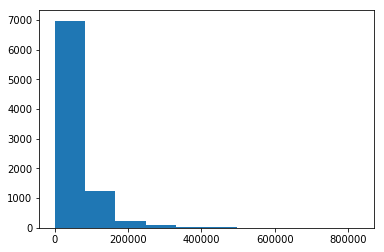

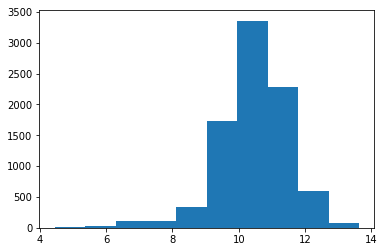

In [14]:
plt.hist(S_train)
plt.show()
plt.hist(np.log(S_train))
plt.show()

In [27]:
X_train_all = X_fold_lc
X_train_t_all = X_fold_time
S_train_all = 1/np.std(X_train_all, axis=1) #all data

X_train_all = np.expand_dims(X_train_all, axis=-1)
X_train_t_all = np.expand_dims(X_train_t_all, axis=-1)
X_train_t_all.shape

(8054, 300, 1)

### Keras models

In [15]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import *

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
def plot_n_lc(real_lc, decoded_lc, n = 10, s=None):
    for _ in range(n):
        n_sampled = np.random.randint(0, real_lc.shape[0])
        
        if s !=None:
            print("Real scale = %f\nPred scale = %f"%(s[0][n_sampled], s[1][n_sampled] ))
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True,figsize= (15,5))
        ax1.plot(real_lc[n_sampled], 'b.-')
        ax1.set_title("Real")
        ax2.plot(decoded_lc[n_sampled], 'b.-')
        ax2.set_title("Reconstructed")
        plt.show()  

        plt.figure(figsize=(15,5))
        plt.plot(real_lc[n_sampled], 'bo-', label="Real")
        plt.plot(decoded_lc[n_sampled], 'g*-', label="Reconstructed")
        plt.title("Over")
        plt.legend()
        plt.show()
        print("----------------------------------------------------------------")

In [16]:
latent_dim = 32
_, T, channels = X_train.shape
D_dim = 5 #o variar: Period", "Duration", "Time of Transit Epoch", "r/R", "a/R",

## Regular VAE

In [17]:
l = 0.001 #kl weight

In [18]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], K.shape(z_mean)[1]), mean=0., stddev=1.)
    return z_mean + K.exp(0.5*z_log_var) * epsilon

def KL_loss(y_true, y_pred):
    return - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

#### IF THIS IS USED,, KL WEIGHT NEEDED TO BE LOW ######
def MSE_loss(y_true, y_pred):
    v = K.mean( K.square( y_true - y_pred ), axis=1) #on time axis..    
    return K.flatten(v)

#### HAS TO BE USED IN ORDER TO LEARN #######
def SSE_loss(y_true, y_pred):
    v = K.sum( K.square( y_true - y_pred ), axis=1) #on time axis..    
    return K.flatten(v)

def vae_loss(y_true, y_pred):
    return MSE_loss(y_true, y_pred) + l*KL_loss(y_true, y_pred)

### KL 1 y represetacion std Global (pesado) 
> No sirve.. Al utilizar KL es dificil que datos de diferente escala qqueden todos en N(0,1)


In [32]:
X_train_SG = X_train*S_mu
X_test_SG = X_test*S_mu

new_S_train = 1/np.std(X_train_SG, axis=1)
train_weights = (new_S_train**2)

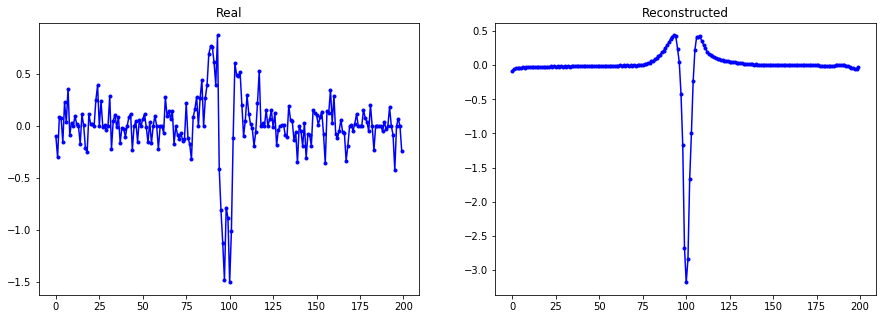

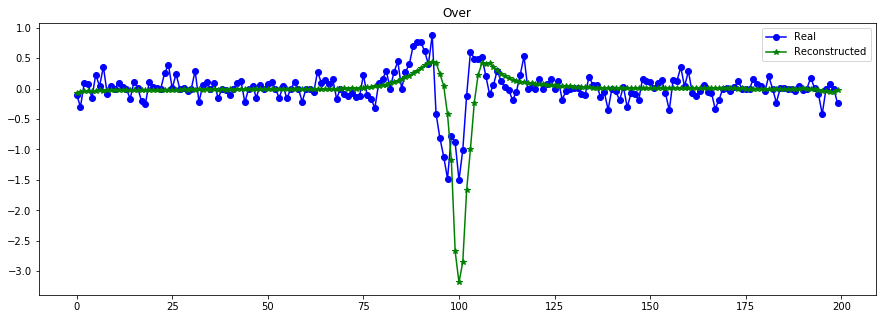

----------------------------------------------------------------


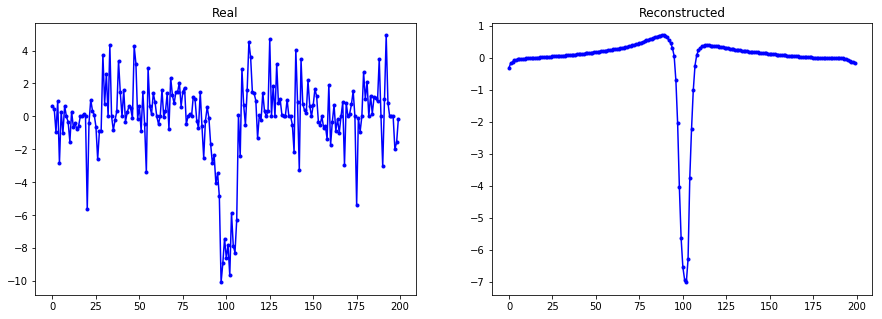

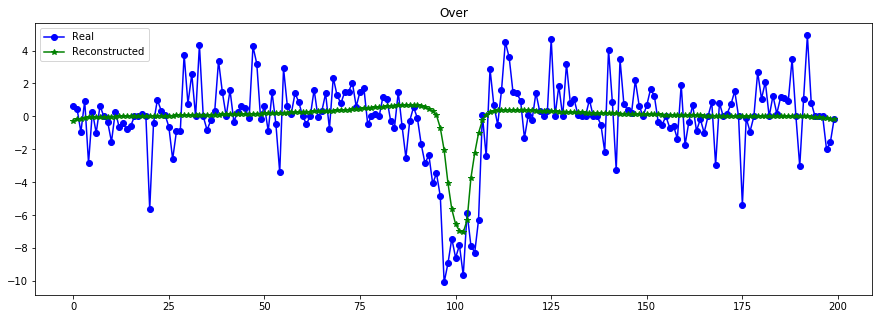

----------------------------------------------------------------


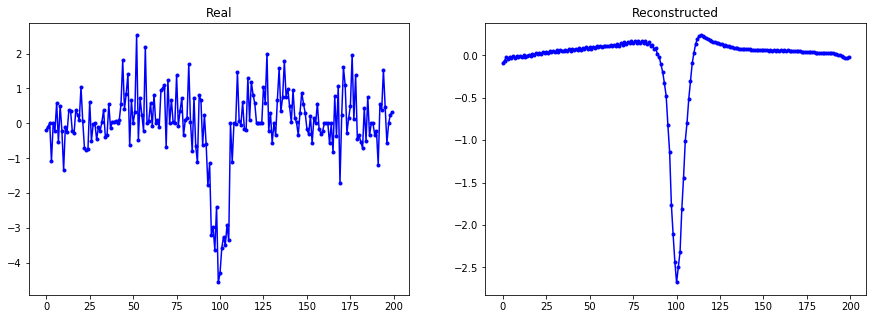

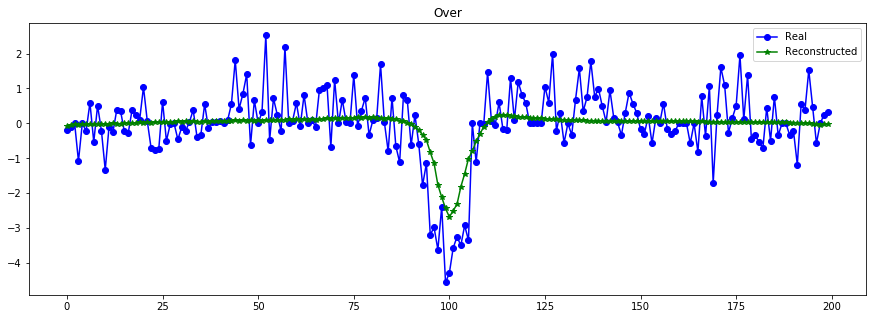

----------------------------------------------------------------


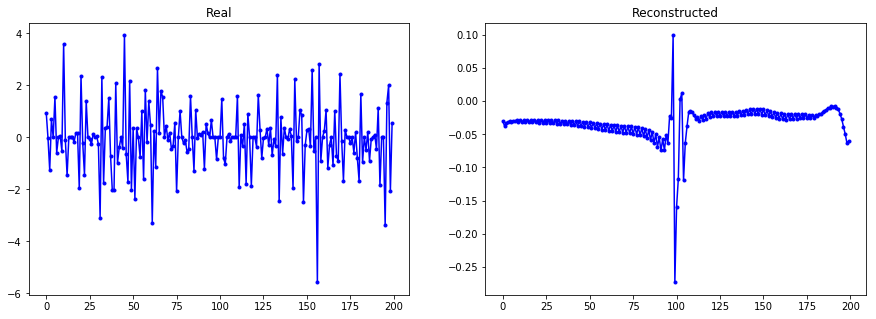

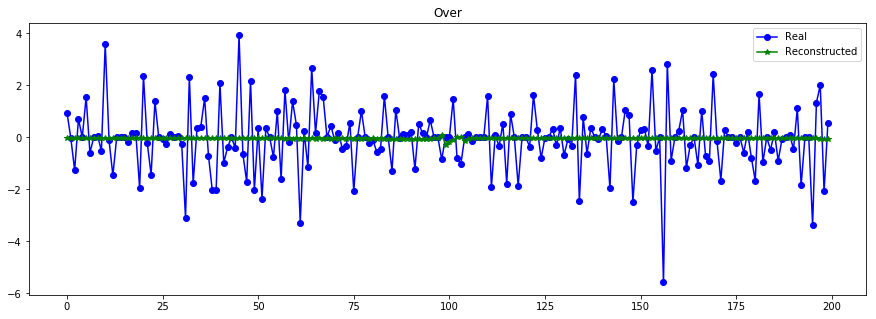

----------------------------------------------------------------


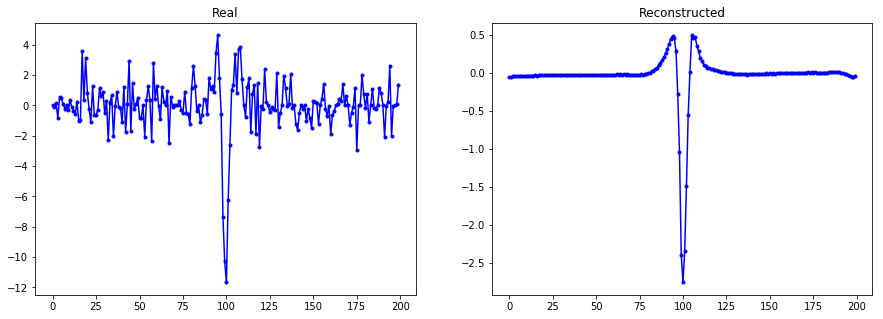

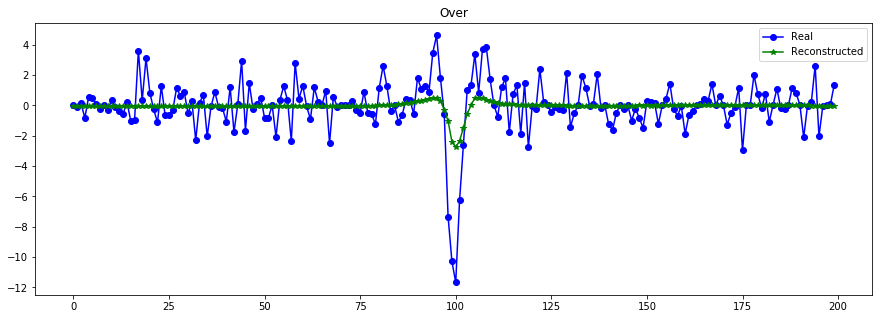

----------------------------------------------------------------


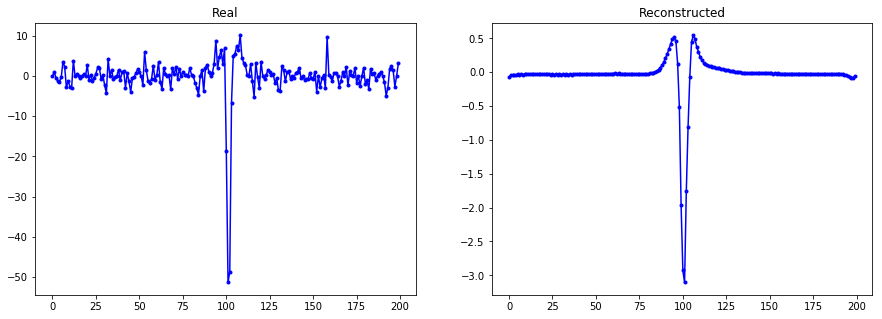

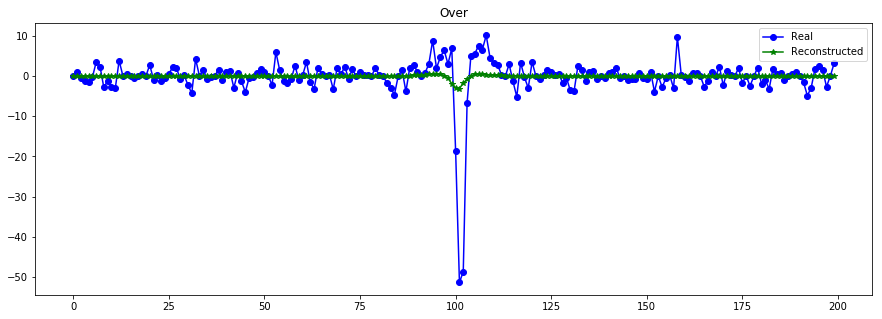

----------------------------------------------------------------


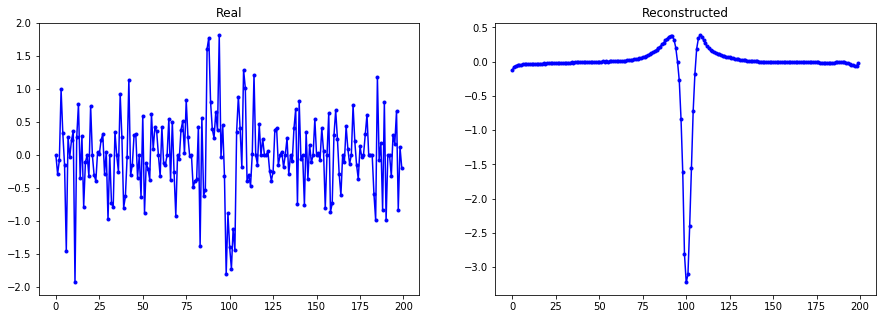

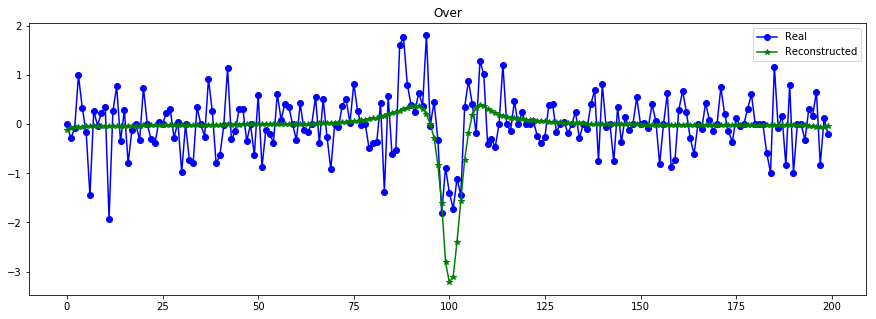

----------------------------------------------------------------


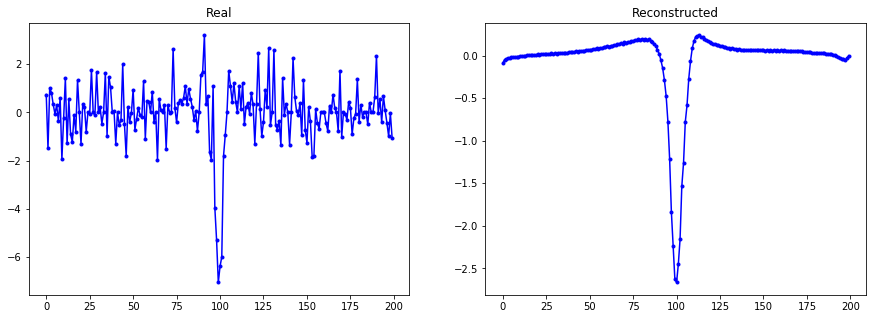

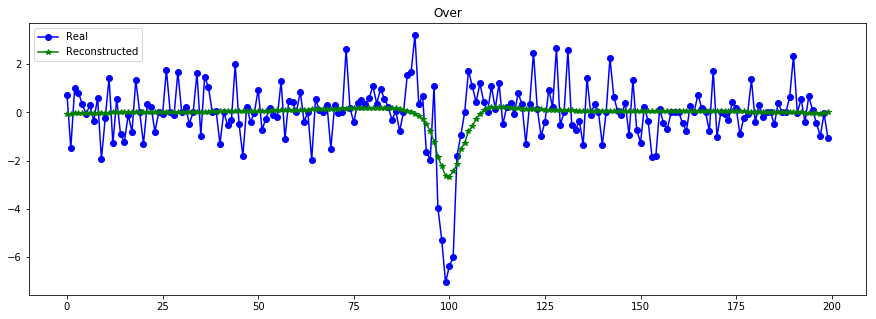

----------------------------------------------------------------


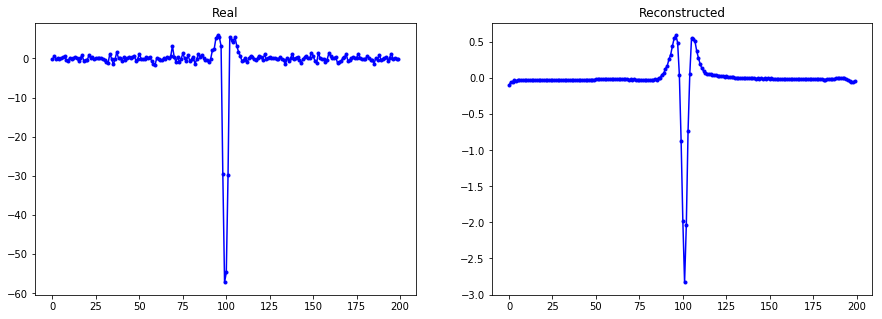

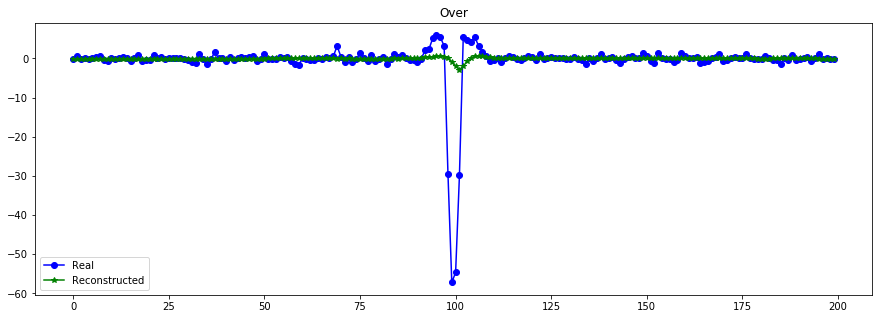

----------------------------------------------------------------


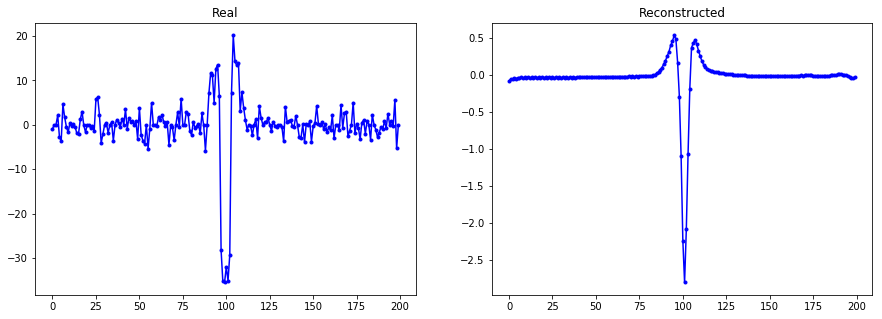

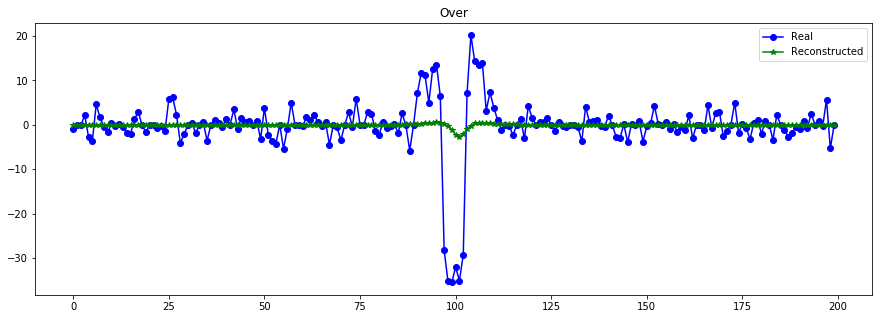

----------------------------------------------------------------


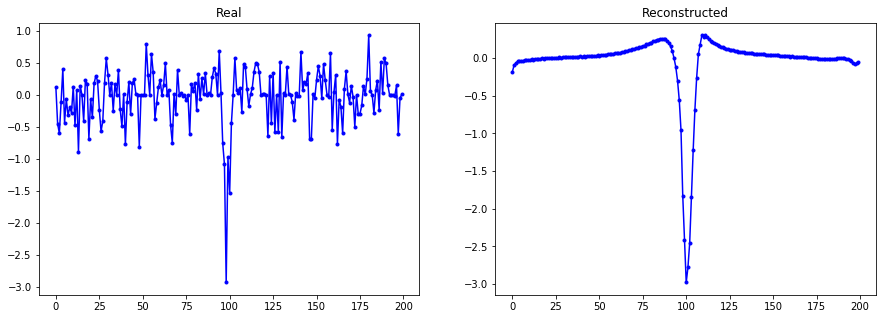

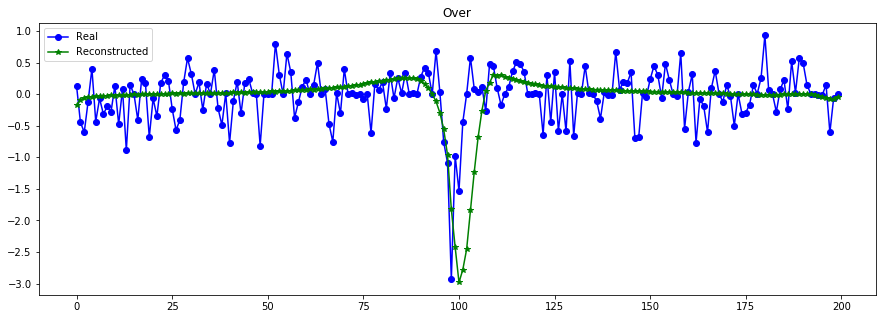

----------------------------------------------------------------


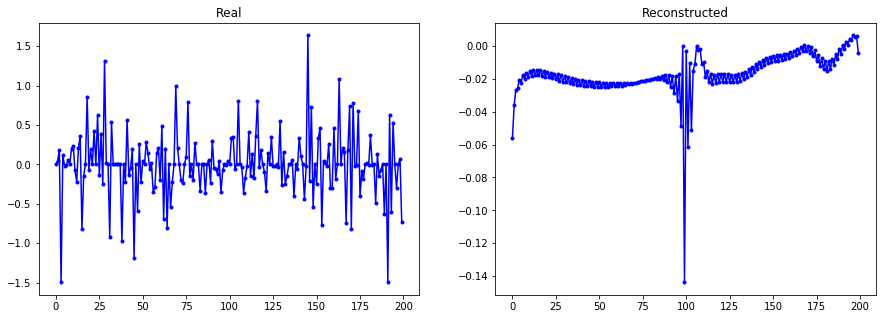

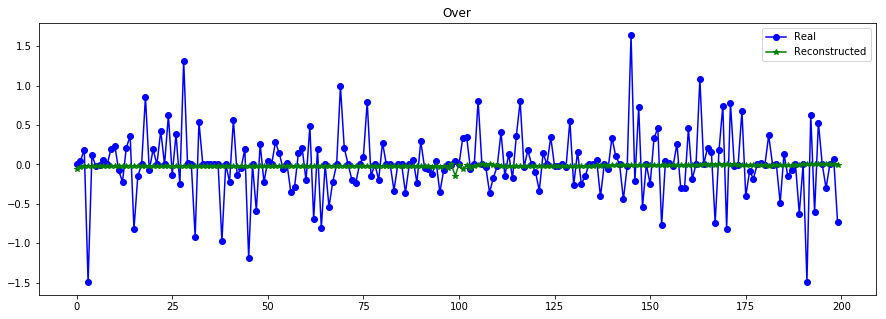

----------------------------------------------------------------


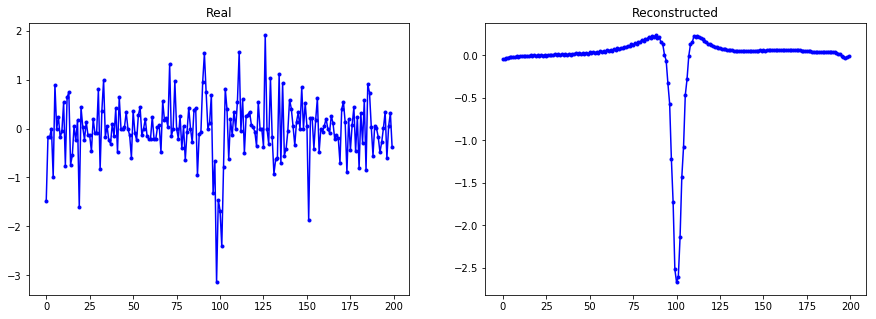

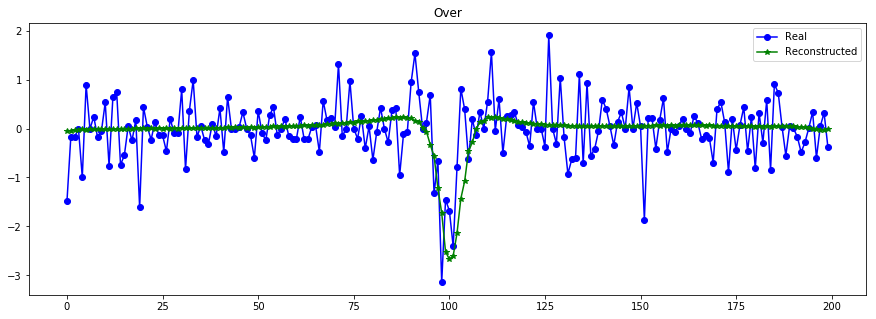

----------------------------------------------------------------


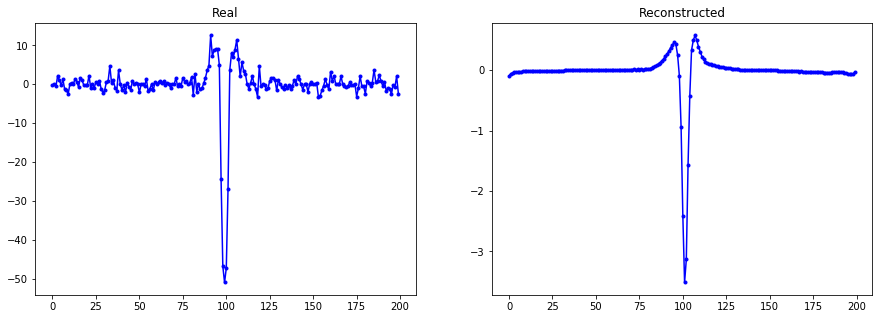

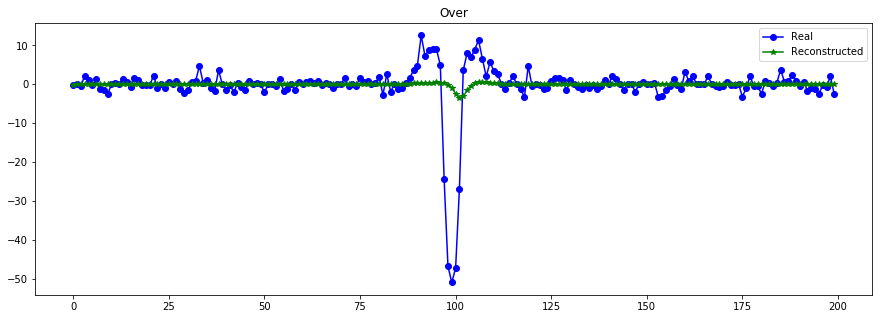

----------------------------------------------------------------


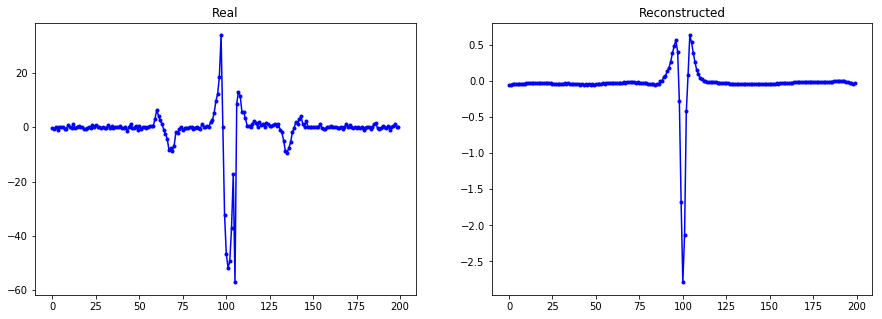

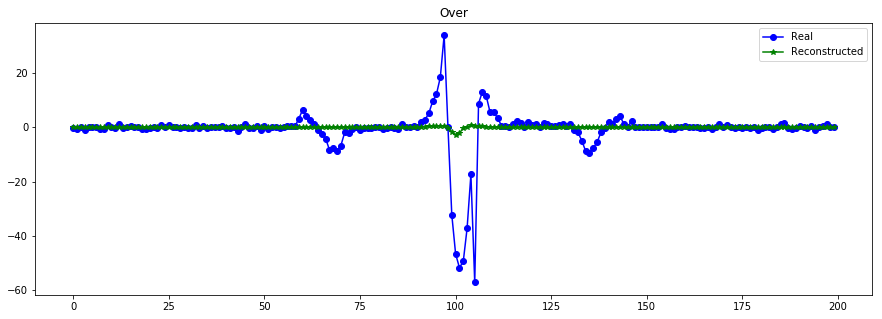

----------------------------------------------------------------


In [25]:
plot_n_lc(X_train_SG[:,:,0], X_train_hat, n= 15) #

In [19]:
def Multiply_layer(args):
    x,s = args
    return x*s[:,None,:]
def Divide_layer(args):
    x,s = args
    return x/s[:,None,:]

def Normalization_L(x,mu,std):
    x = K.log(x) #para normalizar un poco valores gigantes
    return (x - mu)/std
    #return x/std

def RevertNorm_L(x,mu,std):
    return K.exp(std*x + mu)
    #return std*x + mu
    #return std*x
    
Slog_mu = np.mean(np.log(S_train))
Slog_std = np.std(np.log(S_train))
Slog_mu

10.450670099166244

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
T_inp (InputLayer)              (None, 300, 1)       0                                            
__________________________________________________________________________________________________
LC_inp (InputLayer)             (None, 300, 1)       0                                            
__________________________________________________________________________________________________
scale_inp (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
encoder_sampling (Model)        (None, 32)           109128      T_inp[0][0]                      
                                                                 LC_inp[0][0]                     
          

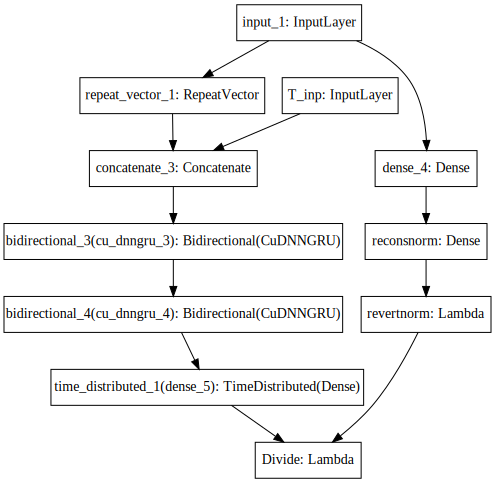

In [20]:
##### INPUTS ENCODER ######
x_lc = Input(shape = (T, channels) , name="LC_inp")
x_t = Input(shape = (T, 1) , name ="T_inp")
s = Input(shape= (1,), name="scale_inp") #para pesar loss

x_lc_s = Lambda(Multiply_layer, name="Multiply")([x_lc, s]) #NEW: escalar data

##### CODIFY LIGHT CURVE ######
x = Concatenate(axis=-1)([x_t, x_lc_s]) 
f1 = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
f1 = Bidirectional(CuDNNGRU(64, return_sequences=False))(f1) 

##### CODIFY SCALE AND CONCATENATE ######
f1_sn = Lambda(Normalization_L, arguments={'mu':Slog_mu,'std':Slog_std}, name="norm")(s) #mas capas?
f1_s = f1_sn
f1_s = Dense(4, activation='tanh')(f1_s) #o tanh

f1 = Concatenate(axis=-1)([f1, f1_s]) #NEW: agregar escala a codificar

##### GET THE LATENT VARIABLE ######
z_mean = Dense(latent_dim,activation='linear')(f1)
z_log_var = Dense(latent_dim,activation='linear')(f1)
encoder = Model([x_t, x_lc, s], z_mean, name="encoder")
z = Lambda(sampling, output_shape=(latent_dim,), name='sample')([z_mean, z_log_var])
samp_encoder = Model([x_t, x_lc, s], z, name="encoder_sampling")

##### INPUTS DECODER ######
decoder_input = Input(shape=(latent_dim,))

##### RECONSTRCT SCALE ######
s_out = Dense(4, activation='tanh')(decoder_input)
s_out = Dense(1, activation='linear', name="reconsnorm")(s_out) #NEW: aprende s 
R_layer = Model(decoder_input, s_out)
s_hat = R_layer(z)
s_out = Lambda(RevertNorm_L, arguments={'mu':Slog_mu,'std':Slog_std},name="revertnorm")(s_out) #NEW: volver a escala normal 
aux_model = Model(decoder_input, s_out)
s_model = Model([x_t, x_lc, s], aux_model(z))

##### RECONSTRUCT LIGHT CURVE ######
decode = RepeatVector(T)(decoder_input)
decode = Concatenate(axis=-1)([x_t, decode]) #add time decode
decode = Bidirectional(CuDNNGRU(64, return_sequences=True))(decode) #bidirectional
decode = Bidirectional(CuDNNGRU(64, return_sequences=True))(decode) #bidirectional
decode = TimeDistributed(Dense(1, activation='linear'))(decode)

decode = Lambda(Divide_layer, name="Divide")([decode, s_out]) #NEW: 

generator = Model([x_t, decoder_input], decode, name="generator")

##### VAE MODEL ######
out = generator([x_t, samp_encoder([x_t, x_lc, s])])
vae = Model([x_t, x_lc, s], out)

def MSE_scale(y_true, y_pred):
    return K.mean( K.square( f1_sn - s_hat ), axis=-1)

def Wvae_loss(y_true, y_pred):
    mse_LC = MSE_loss(y_true, y_pred)
    weights = K.square(s)[:,0]
    wmse_LC = mse_LC * weights #both values has to be on same shape
    
    mse_S = MSE_scale(y_true, y_pred)
    
    kl_loss = KL_loss(y_true, y_pred)
    
    return wmse_LC + l*kl_loss #+ 2*mse_S 

vae.compile(optimizer='adam', loss=Wvae_loss, metrics = [MSE_loss, KL_loss, MSE_scale])
vae.summary()

SVG(model_to_dot(generator).create(prog='dot', format='svg'))

### loss normal de VAE

In [22]:
batch_size = 64

hist = vae.fit([X_train_t, X_train, S_train], X_train, epochs=400, batch_size=batch_size)
        #validation_split=0.25) 

Epoch 1/400
8634/8634 [==============================] - 32s 4ms/step - loss: 1.2890 - MSE_loss: 1.3078e-07 - KL_loss: 11.4291 - MSE_scale: 3.4475
Epoch 2/400
8634/8634 [==============================] - 26s 3ms/step - loss: 1.0189 - MSE_loss: 1.3068e-07 - KL_loss: 9.3858 - MSE_scale: 3.7542
Epoch 3/400
8634/8634 [==============================] - 27s 3ms/step - loss: 1.0121 - MSE_loss: 1.3068e-07 - KL_loss: 6.4483 - MSE_scale: 3.4932
Epoch 4/400
8634/8634 [==============================] - 26s 3ms/step - loss: 1.0092 - MSE_loss: 1.3068e-07 - KL_loss: 4.6929 - MSE_scale: 3.1682
Epoch 5/400
8634/8634 [==============================] - 27s 3ms/step - loss: 1.0079 - MSE_loss: 1.3068e-07 - KL_loss: 3.7316 - MSE_scale: 2.9093
Epoch 6/400
8634/8634 [==============================] - 26s 3ms/step - loss: 1.0087 - MSE_loss: 1.3067e-07 - KL_loss: 4.0274 - MSE_scale: 3.0608
Epoch 7/400
8634/8634 [==============================] - 26s 3ms/step - loss: 1.0079 - MSE_loss: 1.3068e-07 - KL_loss: 3.51

8634/8634 [==============================] - 26s 3ms/step - loss: 1.0040 - MSE_loss: 1.3067e-07 - KL_loss: 1.2276 - MSE_scale: 3.2437
Epoch 57/400
8634/8634 [==============================] - 26s 3ms/step - loss: 1.0034 - MSE_loss: 1.3066e-07 - KL_loss: 0.7084 - MSE_scale: 2.6588
Epoch 58/400
8634/8634 [==============================] - 26s 3ms/step - loss: 1.0043 - MSE_loss: 1.3067e-07 - KL_loss: 1.6271 - MSE_scale: 3.9614
Epoch 59/400
8634/8634 [==============================] - 25s 3ms/step - loss: 1.0031 - MSE_loss: 1.3066e-07 - KL_loss: 0.6909 - MSE_scale: 2.7880
Epoch 60/400
8634/8634 [==============================] - 26s 3ms/step - loss: 1.0033 - MSE_loss: 1.3067e-07 - KL_loss: 0.7107 - MSE_scale: 2.8816
Epoch 61/400
8634/8634 [==============================] - 26s 3ms/step - loss: 1.0031 - MSE_loss: 1.3066e-07 - KL_loss: 0.7572 - MSE_scale: 3.1449
Epoch 62/400
8634/8634 [==============================] - 25s 3ms/step - loss: 1.0032 - MSE_loss: 1.3067e-07 - KL_loss: 0.6941 - MS

8634/8634 [==============================] - 25s 3ms/step - loss: 0.8217 - MSE_loss: 1.1498e-07 - KL_loss: 12.9521 - MSE_scale: 0.7269
Epoch 112/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.8174 - MSE_loss: 1.1259e-07 - KL_loss: 13.1573 - MSE_scale: 0.7419
Epoch 113/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.8291 - MSE_loss: 1.1062e-07 - KL_loss: 11.9313 - MSE_scale: 0.8053
Epoch 114/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.8121 - MSE_loss: 1.0784e-07 - KL_loss: 11.5817 - MSE_scale: 0.8010
Epoch 115/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.8032 - MSE_loss: 1.0536e-07 - KL_loss: 12.4371 - MSE_scale: 0.7660
Epoch 116/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7882 - MSE_loss: 1.0171e-07 - KL_loss: 12.4784 - MSE_scale: 0.7896
Epoch 117/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7950 - MSE_loss: 9.8243e-08 - KL_loss:

8634/8634 [==============================] - 25s 3ms/step - loss: 0.7533 - MSE_loss: 3.9665e-08 - KL_loss: 10.7901 - MSE_scale: 1.2418
Epoch 167/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7444 - MSE_loss: 4.0032e-08 - KL_loss: 10.7540 - MSE_scale: 1.2528
Epoch 168/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7528 - MSE_loss: 4.1591e-08 - KL_loss: 10.6728 - MSE_scale: 1.3160
Epoch 169/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7456 - MSE_loss: 3.7656e-08 - KL_loss: 10.6956 - MSE_scale: 1.3119
Epoch 170/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7341 - MSE_loss: 3.8097e-08 - KL_loss: 10.9804 - MSE_scale: 1.2465
Epoch 171/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7505 - MSE_loss: 3.8013e-08 - KL_loss: 10.9657 - MSE_scale: 1.2119
Epoch 172/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7456 - MSE_loss: 3.9970e-08 - KL_loss:

8634/8634 [==============================] - 26s 3ms/step - loss: 0.7959 - MSE_loss: 5.2548e-08 - KL_loss: 14.6414 - MSE_scale: 1.7750
Epoch 222/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7721 - MSE_loss: 4.8791e-08 - KL_loss: 14.4519 - MSE_scale: 1.8291
Epoch 223/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7788 - MSE_loss: 5.0365e-08 - KL_loss: 14.4032 - MSE_scale: 1.8131
Epoch 224/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7638 - MSE_loss: 4.6512e-08 - KL_loss: 14.3743 - MSE_scale: 1.7874
Epoch 225/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7734 - MSE_loss: 4.8385e-08 - KL_loss: 14.0952 - MSE_scale: 1.8180
Epoch 226/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7660 - MSE_loss: 4.7438e-08 - KL_loss: 14.0717 - MSE_scale: 1.8282
Epoch 227/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7467 - MSE_loss: 4.3178e-08 - KL_loss:

8634/8634 [==============================] - 26s 3ms/step - loss: 0.7154 - MSE_loss: 2.8999e-08 - KL_loss: 12.9581 - MSE_scale: 1.8388
Epoch 277/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7251 - MSE_loss: 3.0654e-08 - KL_loss: 12.6322 - MSE_scale: 1.8814
Epoch 278/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7264 - MSE_loss: 2.9983e-08 - KL_loss: 12.4581 - MSE_scale: 1.8263
Epoch 279/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7071 - MSE_loss: 2.5176e-08 - KL_loss: 12.6077 - MSE_scale: 1.8582
Epoch 280/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7357 - MSE_loss: 3.1450e-08 - KL_loss: 12.5683 - MSE_scale: 1.8061
Epoch 281/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7657 - MSE_loss: 3.3521e-08 - KL_loss: 15.5938 - MSE_scale: 0.9804
Epoch 282/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7555 - MSE_loss: 3.0819e-08 - KL_loss:

8634/8634 [==============================] - 26s 3ms/step - loss: 0.7939 - MSE_loss: 3.6322e-08 - KL_loss: 43.5444 - MSE_scale: 1.2219
Epoch 332/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7875 - MSE_loss: 3.3170e-08 - KL_loss: 43.5425 - MSE_scale: 1.2170
Epoch 333/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.8337 - MSE_loss: 4.7151e-08 - KL_loss: 43.5399 - MSE_scale: 1.4045
Epoch 334/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7901 - MSE_loss: 3.3245e-08 - KL_loss: 43.5362 - MSE_scale: 1.1646
Epoch 335/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7891 - MSE_loss: 3.4407e-08 - KL_loss: 43.5351 - MSE_scale: 1.1716
Epoch 336/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.8014 - MSE_loss: 3.5479e-08 - KL_loss: 43.5324 - MSE_scale: 1.2268
Epoch 337/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7767 - MSE_loss: 3.3498e-08 - KL_loss:

8634/8634 [==============================] - 25s 3ms/step - loss: 0.7619 - MSE_loss: 2.9382e-08 - KL_loss: 43.2839 - MSE_scale: 1.0759
Epoch 387/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7644 - MSE_loss: 3.2058e-08 - KL_loss: 43.2646 - MSE_scale: 1.1244
Epoch 388/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7895 - MSE_loss: 3.2604e-08 - KL_loss: 43.2376 - MSE_scale: 1.1883
Epoch 389/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7819 - MSE_loss: 3.1382e-08 - KL_loss: 43.2234 - MSE_scale: 1.1639
Epoch 390/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.8042 - MSE_loss: 3.5853e-08 - KL_loss: 43.2006 - MSE_scale: 1.2131
Epoch 391/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7922 - MSE_loss: 3.4678e-08 - KL_loss: 43.1725 - MSE_scale: 1.1207
Epoch 392/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.8356 - MSE_loss: 3.8969e-08 - KL_loss:

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


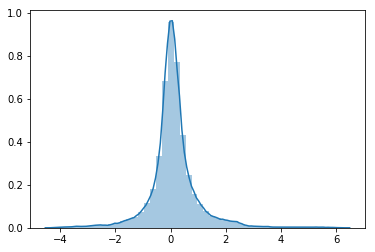

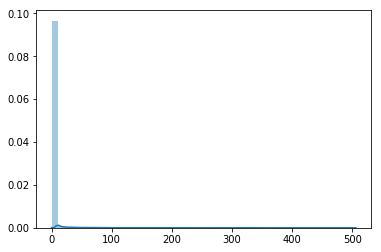

In [23]:
encoder_all = Model([x_t, x_lc,s], [z_mean, z_log_var], name="encoder")
z_aux, z_var_aux = encoder_all.predict([X_train_t,X_train, S_train], batch_size=512)

sns.distplot(z_aux.flatten())
plt.show()
sns.distplot(np.exp(z_var_aux.flatten()))
plt.show()

----- EVALUANDO RECONSTRUCCION DE LA CURVA -----


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


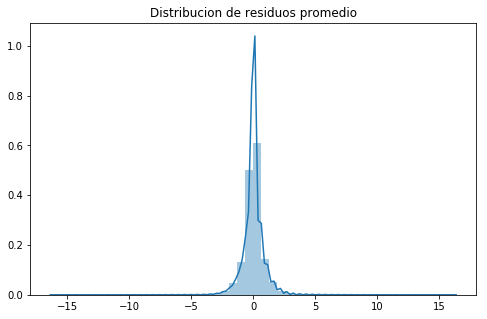

MSE      =  0.6962120074740263
RMSE (+-)=  0.8109581984574059
MAE  (+-)=  0.5191557483323184
--------- Smoothness ------------
AutoCorr lag-one =  0.8836251044170177
Diff MEAN =  0.03278605742671098
Diff STD =  0.13745297287535993
--------- Smoothness ------------
MSE de escala escalado=  482.813432332647


array([[3.1087054e+02],
       [1.5963703e+04],
       [4.4294852e+04],
       ...,
       [1.4332772e+04],
       [1.9134682e+06],
       [2.0732324e+04]], dtype=float32)

In [24]:
X_train_hat = vae.predict([X_train_t[:N], X_train[:N], S_train[:N]], batch_size=512)
evaluate_reconst(X_train[:N]*S_train[:N,None,:], X_train_hat*S_train[:N,None,:])

S_train_hat = s_model.predict([X_train_t[:N],X_train[:N], S_train[:N]], batch_size=512)
print("MSE de escala escalado= ",scaled_MSE((S_train[:N]-S_mu)/S_std, (S_train_hat-S_mu)/S_std,1 ))
S_train_hat

Real scale = 9484.801004
Pred scale = 7037.355957


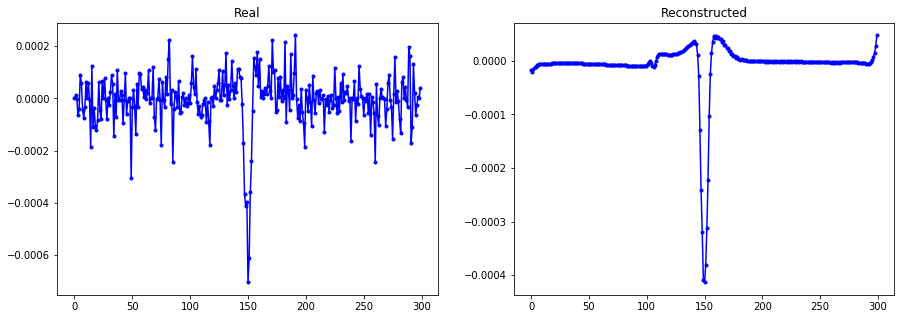

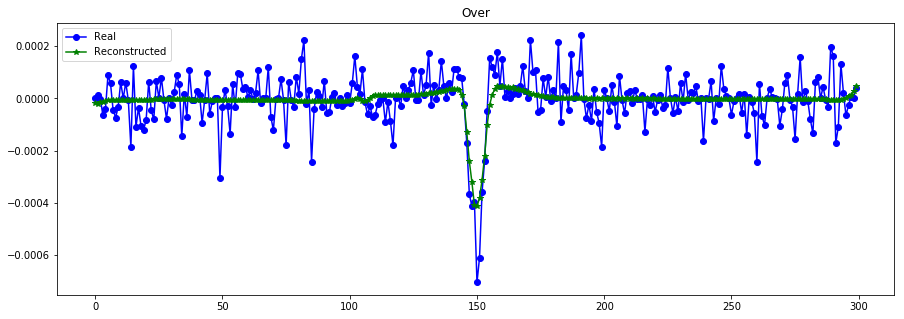

----------------------------------------------------------------
Real scale = 56711.888561
Pred scale = 18013.482422


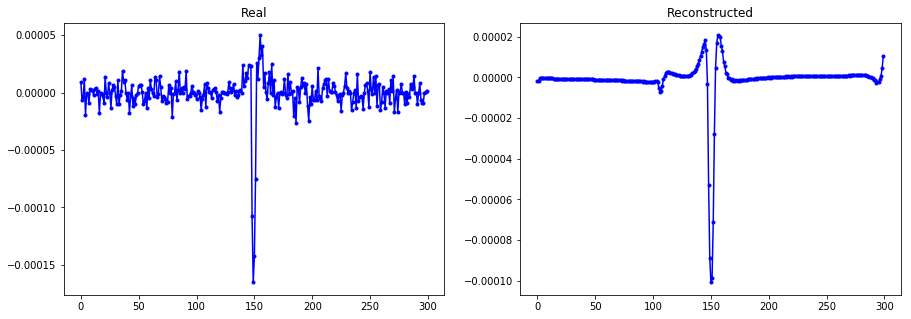

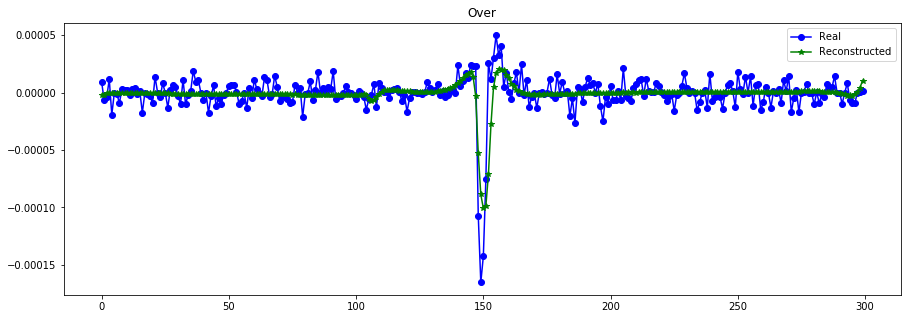

----------------------------------------------------------------
Real scale = 21760.682757
Pred scale = 13497.458984


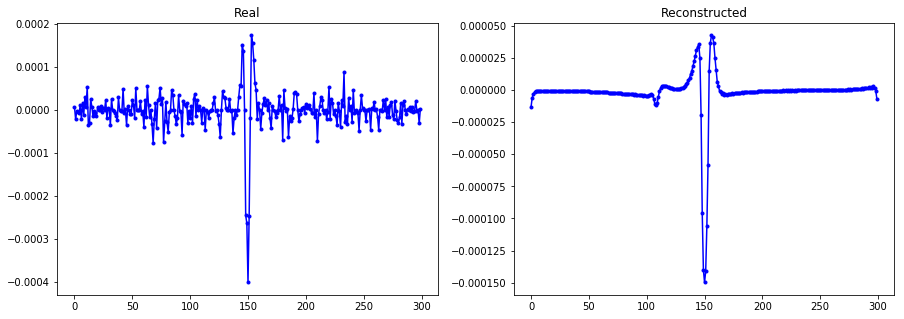

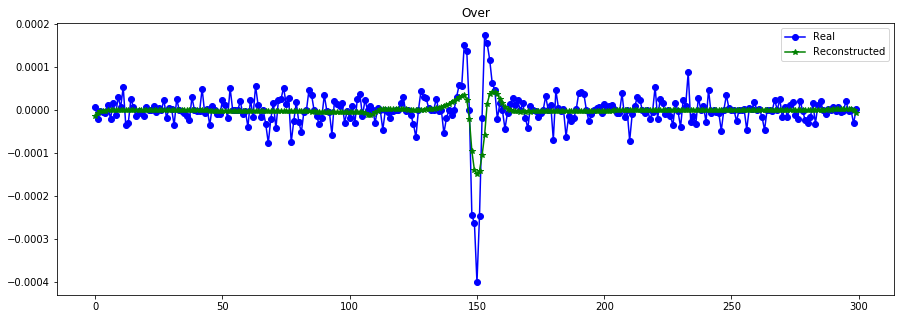

----------------------------------------------------------------
Real scale = 134068.231723
Pred scale = 268903.937500


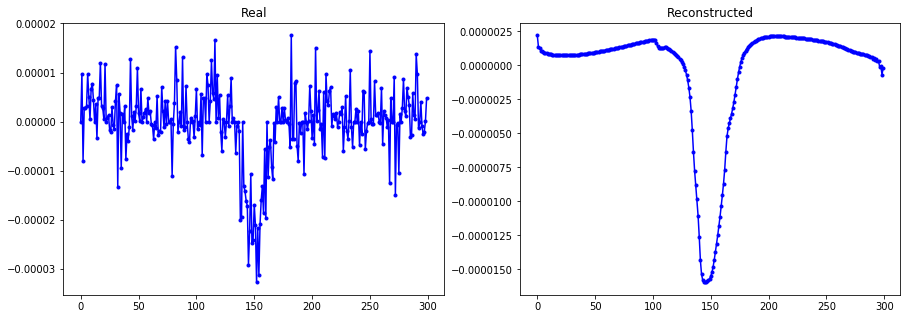

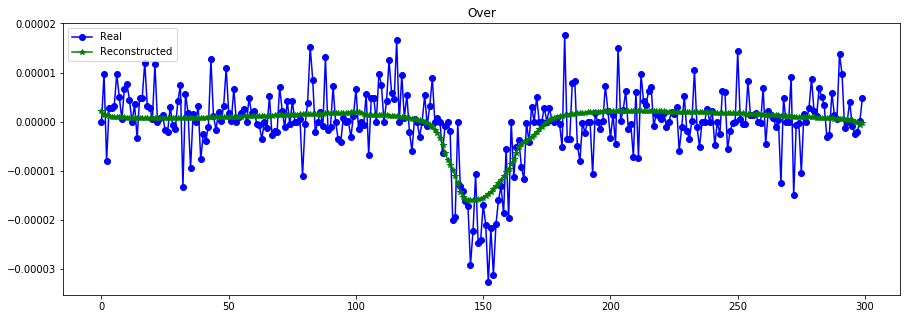

----------------------------------------------------------------
Real scale = 29563.096272
Pred scale = 22164.548828


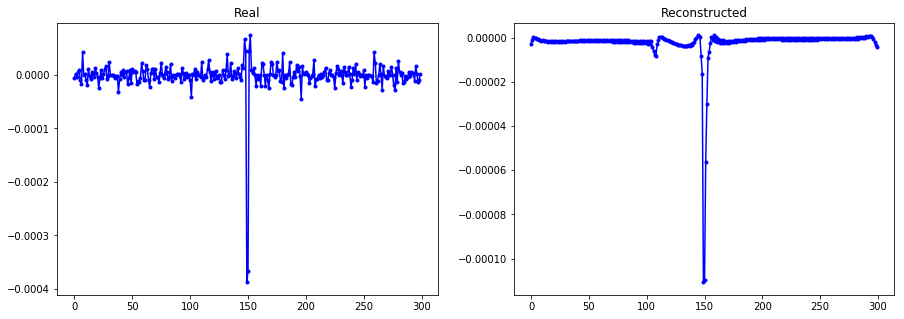

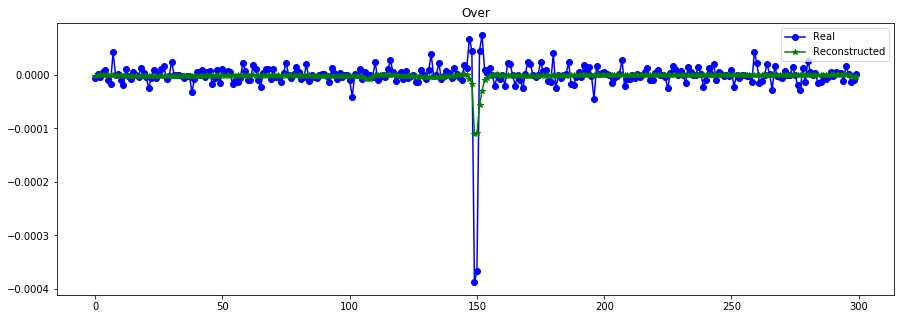

----------------------------------------------------------------
Real scale = 19210.290346
Pred scale = 20448.404297


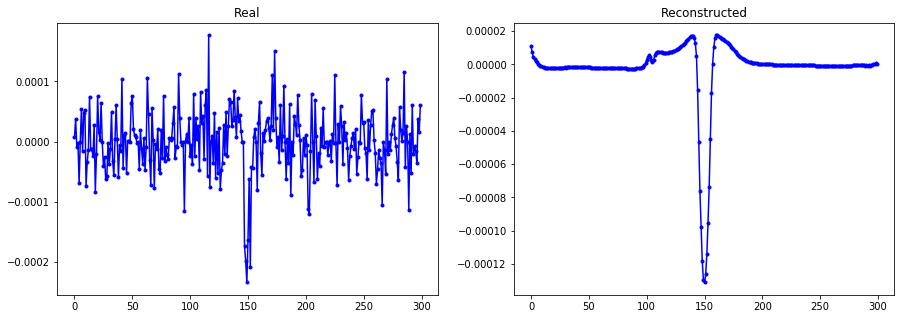

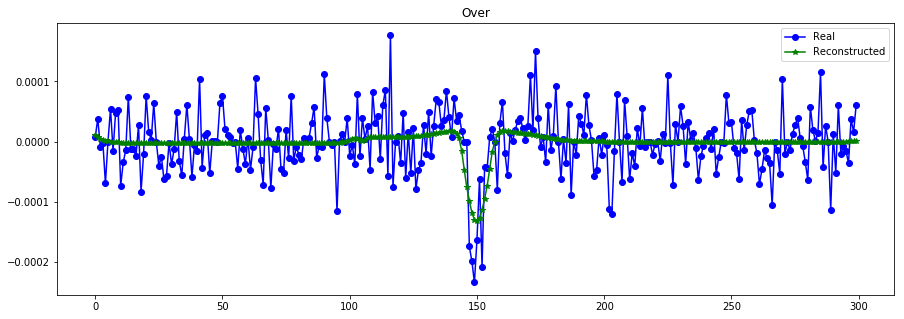

----------------------------------------------------------------
Real scale = 73113.811038
Pred scale = 594486.375000


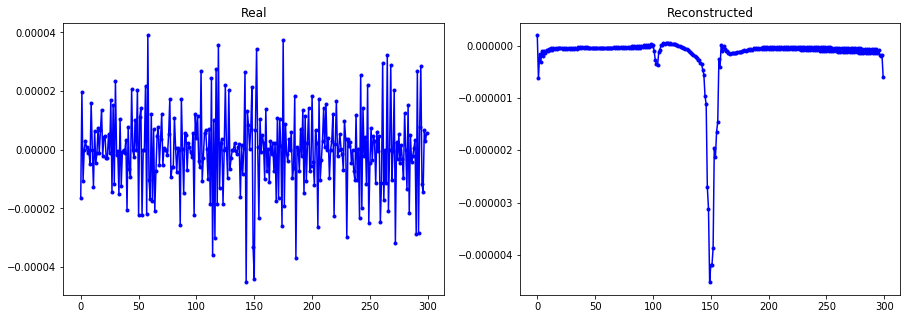

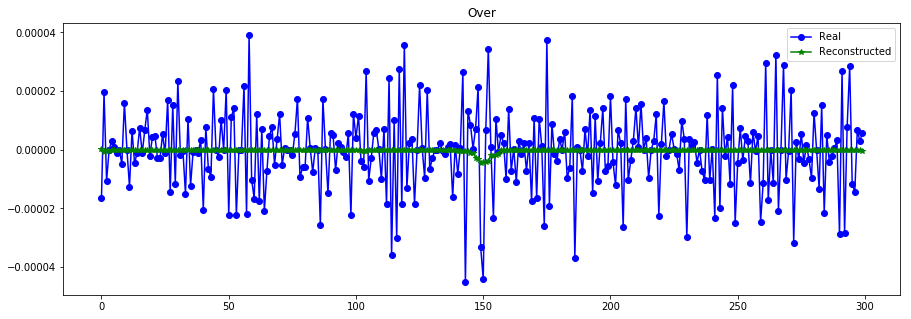

----------------------------------------------------------------
Real scale = 49948.986459
Pred scale = 57228.550781


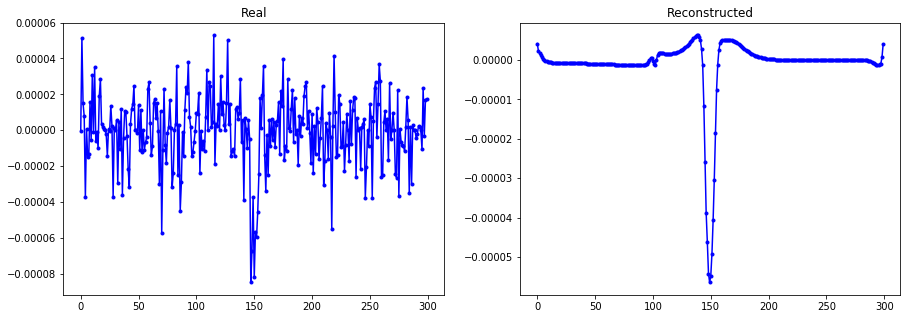

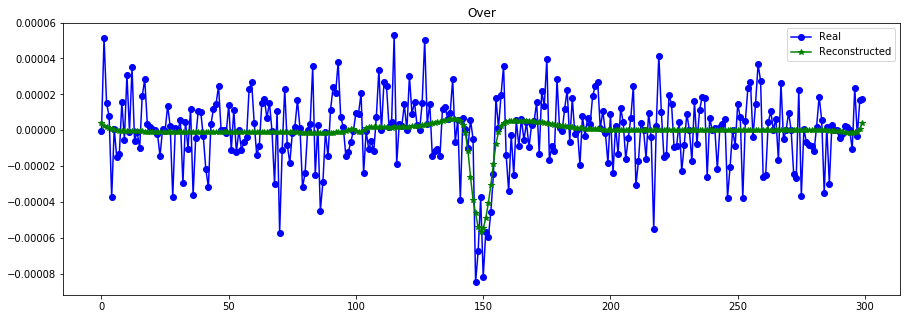

----------------------------------------------------------------
Real scale = 98990.870567
Pred scale = 296633.343750


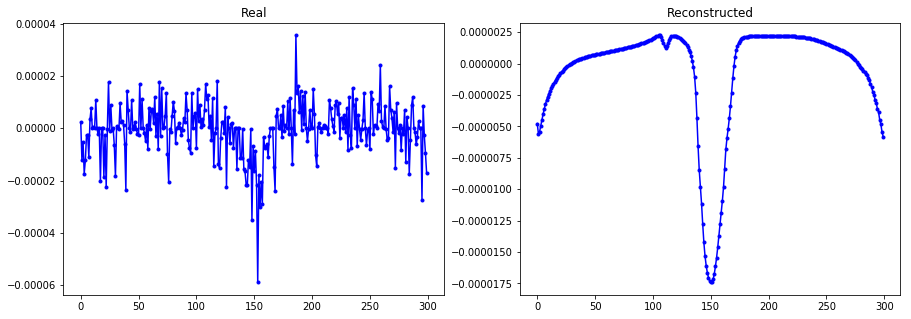

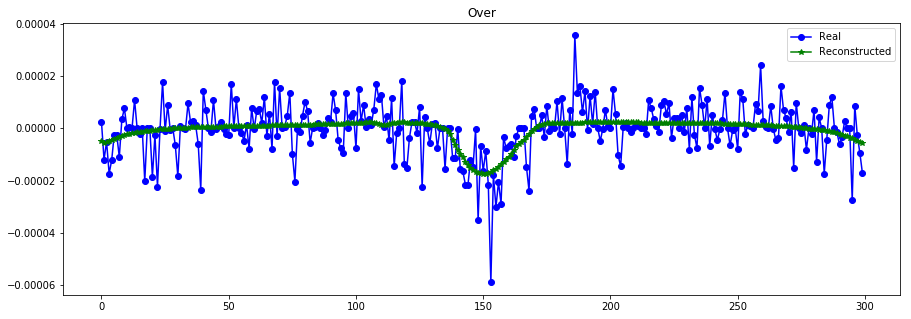

----------------------------------------------------------------
Real scale = 23922.119935
Pred scale = 21763.787109


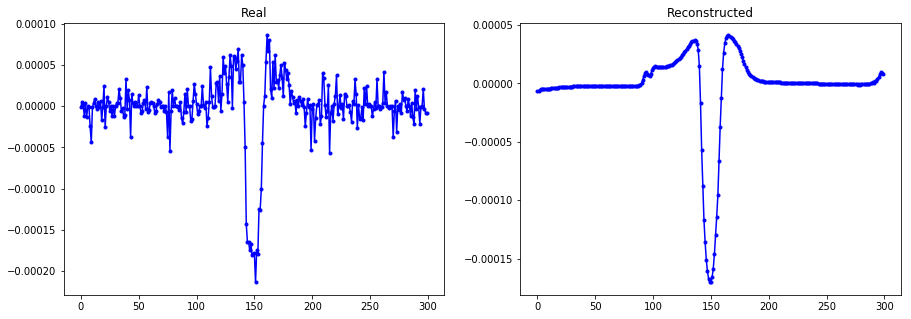

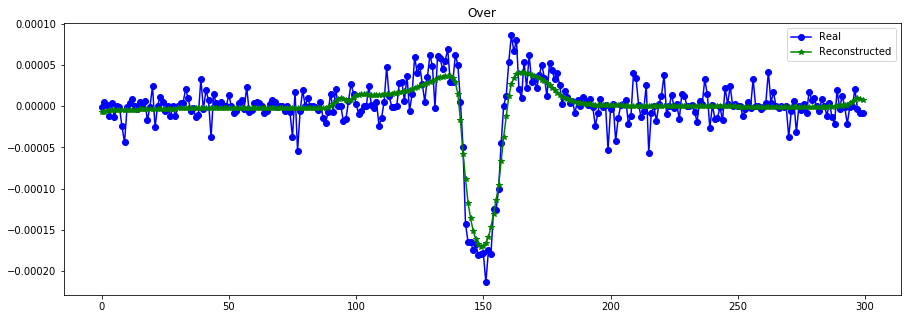

----------------------------------------------------------------
Real scale = 45127.251189
Pred scale = 759455.937500


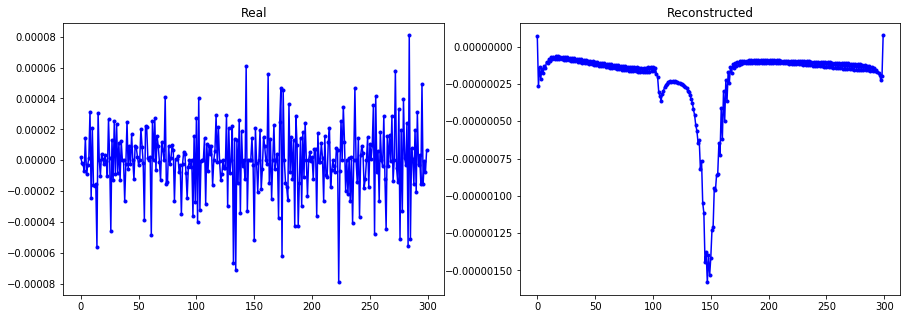

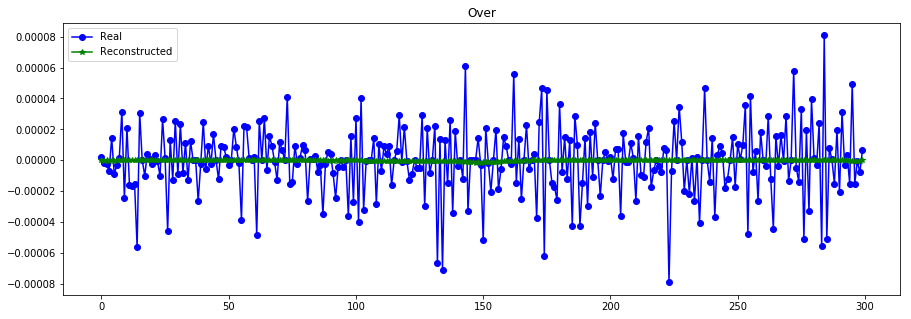

----------------------------------------------------------------
Real scale = 25732.254228
Pred scale = 11835.542969


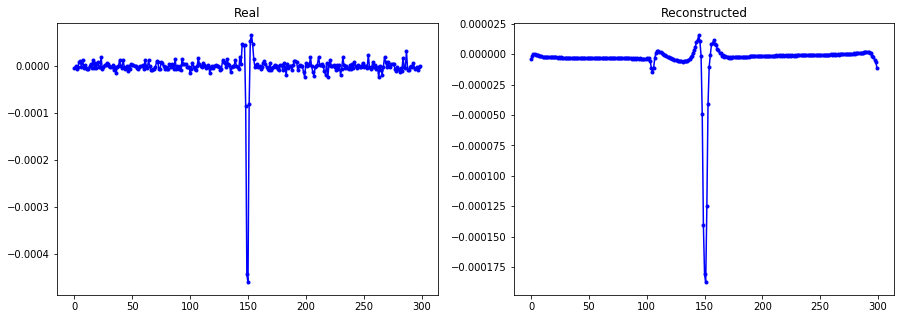

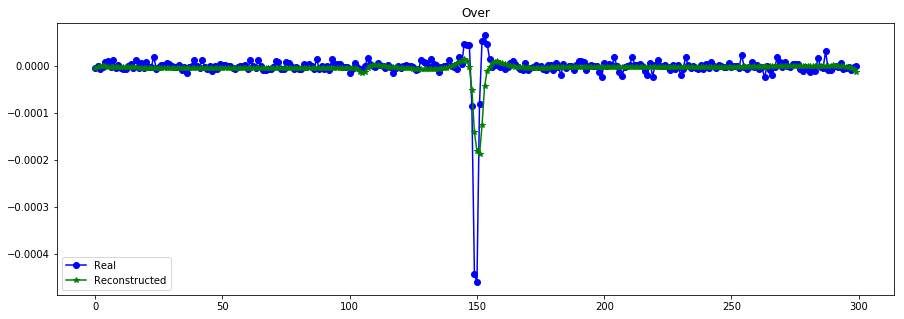

----------------------------------------------------------------
Real scale = 21338.048304
Pred scale = 25052.666016


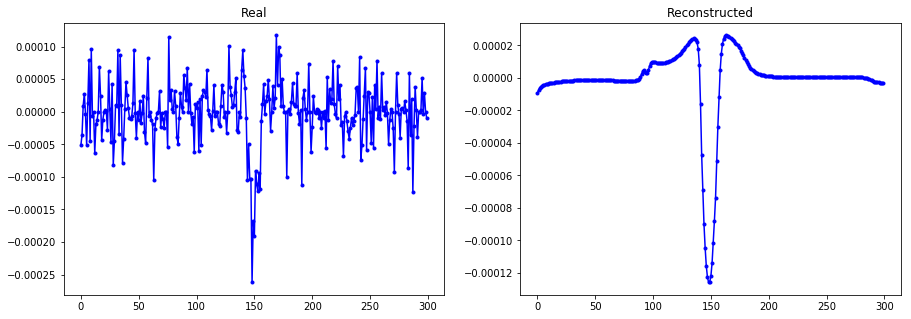

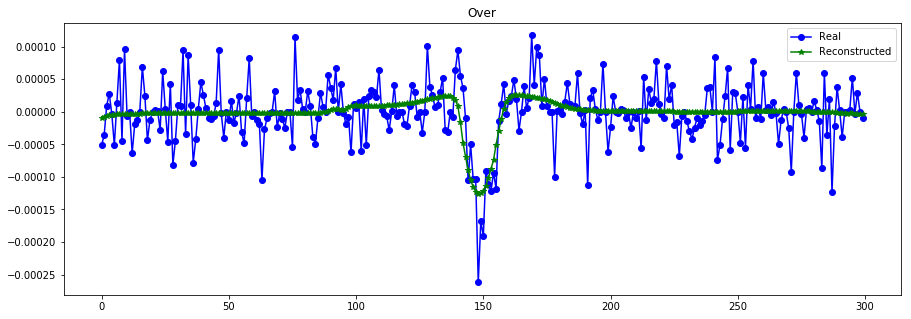

----------------------------------------------------------------
Real scale = 24593.559630
Pred scale = 21939.964844


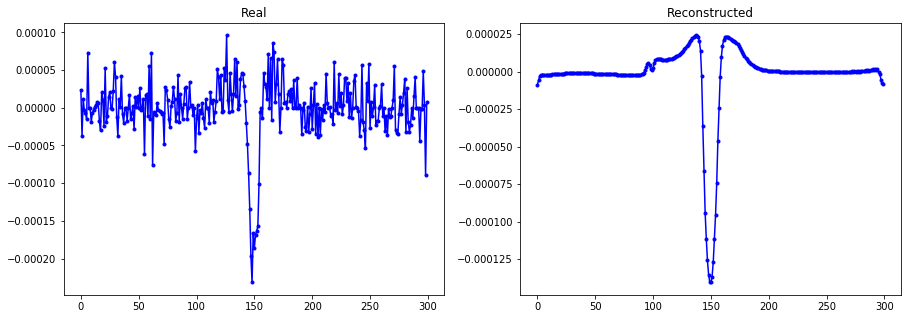

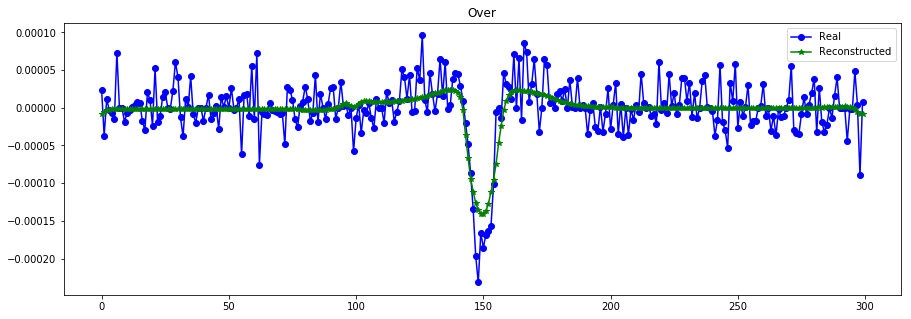

----------------------------------------------------------------
Real scale = 461509.059294
Pred scale = 679875.250000


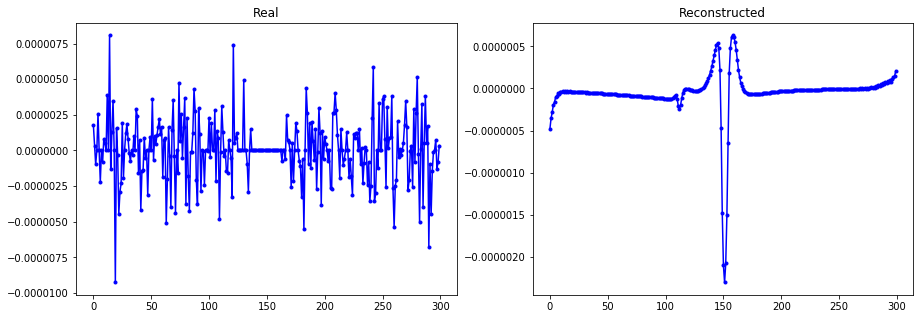

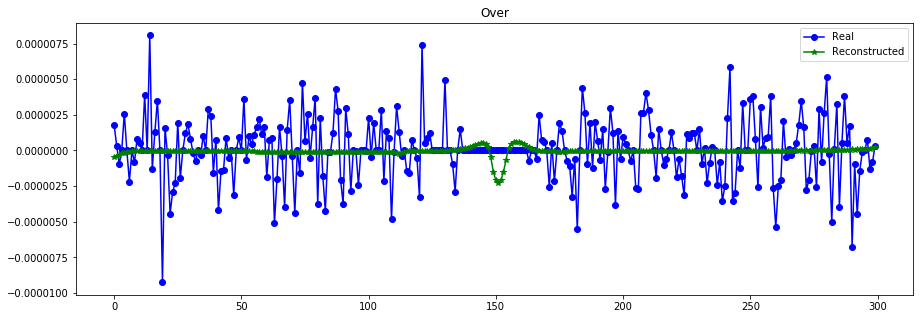

----------------------------------------------------------------


In [25]:
plot_n_lc(X_train[:N,:,0], X_train_hat, n= 15, s=[S_train[:N],S_train_hat]) #

In [26]:
vae.save_weights("./models/%dT_%dD_%de_VAE_scale.h5"%(T,latent_dim,400))

### con loss sobre escala tambien

In [28]:
def Wvae_loss(y_true, y_pred):
    mse_LC = MSE_loss(y_true, y_pred)
    weights = K.square(s)[:,0]
    wmse_LC = mse_LC * weights #both values has to be on same shape
    
    mse_S = MSE_scale(y_true, y_pred)
    
    kl_loss = KL_loss(y_true, y_pred)
    
    return wmse_LC + l*kl_loss + mse_S 

vae.compile(optimizer='adam', loss=Wvae_loss, metrics = [MSE_loss, KL_loss, MSE_scale])
batch_size = 64

hist = vae.fit([X_train_t, X_train, S_train], X_train, epochs=400, batch_size=batch_size)
        #validation_split=0.25) 

Epoch 1/400
8634/8634 [==============================] - 29s 3ms/step - loss: 2.5360 - MSE_loss: 1.3078e-07 - KL_loss: 1.0638 - MSE_scale: 1.1738
Epoch 2/400
8634/8634 [==============================] - 25s 3ms/step - loss: 1.3973 - MSE_loss: 1.3065e-07 - KL_loss: 26.9931 - MSE_scale: 0.3653
Epoch 3/400
8634/8634 [==============================] - 26s 3ms/step - loss: 1.2026 - MSE_loss: 1.3059e-07 - KL_loss: 40.7626 - MSE_scale: 0.1600
Epoch 4/400
8634/8634 [==============================] - 26s 3ms/step - loss: 1.1754 - MSE_loss: 1.3056e-07 - KL_loss: 39.6960 - MSE_scale: 0.1340
Epoch 5/400
8634/8634 [==============================] - 25s 3ms/step - loss: 1.1621 - MSE_loss: 1.3051e-07 - KL_loss: 39.4320 - MSE_scale: 0.1210
Epoch 6/400
8634/8634 [==============================] - 26s 3ms/step - loss: 1.1521 - MSE_loss: 1.3048e-07 - KL_loss: 39.8275 - MSE_scale: 0.1108
Epoch 7/400
8634/8634 [==============================] - 26s 3ms/step - loss: 1.1392 - MSE_loss: 1.3037e-07 - KL_loss: 

8634/8634 [==============================] - 25s 3ms/step - loss: 0.8480 - MSE_loss: 5.4812e-08 - KL_loss: 34.7800 - MSE_scale: 0.0055
Epoch 57/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.8678 - MSE_loss: 5.3499e-08 - KL_loss: 34.1974 - MSE_scale: 0.0054
Epoch 58/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.8502 - MSE_loss: 5.4912e-08 - KL_loss: 34.1996 - MSE_scale: 0.0052
Epoch 59/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.8596 - MSE_loss: 5.3021e-08 - KL_loss: 32.9082 - MSE_scale: 0.0058
Epoch 60/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.8281 - MSE_loss: 5.0560e-08 - KL_loss: 34.0470 - MSE_scale: 0.0048
Epoch 61/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.8468 - MSE_loss: 5.1558e-08 - KL_loss: 32.8542 - MSE_scale: 0.0050
Epoch 62/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.8343 - MSE_loss: 4.6934e-08 - KL_loss: 32.45

8634/8634 [==============================] - 25s 3ms/step - loss: 0.7690 - MSE_loss: 3.1226e-08 - KL_loss: 27.0409 - MSE_scale: 0.0031
Epoch 112/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7744 - MSE_loss: 3.2419e-08 - KL_loss: 27.0491 - MSE_scale: 0.0028
Epoch 113/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7799 - MSE_loss: 3.2527e-08 - KL_loss: 26.3531 - MSE_scale: 0.0034
Epoch 114/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7703 - MSE_loss: 3.1472e-08 - KL_loss: 26.8888 - MSE_scale: 0.0027
Epoch 115/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7782 - MSE_loss: 3.1162e-08 - KL_loss: 26.1617 - MSE_scale: 0.0029
Epoch 116/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7638 - MSE_loss: 2.8703e-08 - KL_loss: 26.0549 - MSE_scale: 0.0030
Epoch 117/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7857 - MSE_loss: 3.2021e-08 - KL_loss:

8634/8634 [==============================] - 25s 3ms/step - loss: 0.7344 - MSE_loss: 2.7522e-08 - KL_loss: 24.5293 - MSE_scale: 0.0023
Epoch 167/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7309 - MSE_loss: 2.5821e-08 - KL_loss: 24.9942 - MSE_scale: 0.0025
Epoch 168/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7615 - MSE_loss: 2.9036e-08 - KL_loss: 23.9383 - MSE_scale: 0.0029
Epoch 169/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7350 - MSE_loss: 2.5272e-08 - KL_loss: 24.4046 - MSE_scale: 0.0026
Epoch 170/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7573 - MSE_loss: 3.0380e-08 - KL_loss: 23.5534 - MSE_scale: 0.0028
Epoch 171/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7483 - MSE_loss: 2.8169e-08 - KL_loss: 23.9016 - MSE_scale: 0.0030
Epoch 172/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7332 - MSE_loss: 2.5773e-08 - KL_loss:

8634/8634 [==============================] - 25s 3ms/step - loss: 0.7232 - MSE_loss: 2.4356e-08 - KL_loss: 24.1871 - MSE_scale: 0.0023
Epoch 222/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7251 - MSE_loss: 2.4441e-08 - KL_loss: 23.9873 - MSE_scale: 0.0021
Epoch 223/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7151 - MSE_loss: 2.2919e-08 - KL_loss: 24.3585 - MSE_scale: 0.0019
Epoch 224/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7022 - MSE_loss: 2.1009e-08 - KL_loss: 24.0827 - MSE_scale: 0.0019
Epoch 225/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7153 - MSE_loss: 2.2326e-08 - KL_loss: 24.3894 - MSE_scale: 0.0020
Epoch 226/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7142 - MSE_loss: 2.1928e-08 - KL_loss: 24.1870 - MSE_scale: 0.0022
Epoch 227/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7215 - MSE_loss: 2.4412e-08 - KL_loss:

8634/8634 [==============================] - 25s 3ms/step - loss: 0.6977 - MSE_loss: 2.0260e-08 - KL_loss: 24.9054 - MSE_scale: 0.0022
Epoch 277/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6814 - MSE_loss: 1.8412e-08 - KL_loss: 24.7111 - MSE_scale: 0.0018
Epoch 278/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7110 - MSE_loss: 1.9283e-08 - KL_loss: 24.3462 - MSE_scale: 0.0022
Epoch 279/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.6863 - MSE_loss: 2.2749e-08 - KL_loss: 24.4673 - MSE_scale: 0.0019
Epoch 280/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.6812 - MSE_loss: 1.8538e-08 - KL_loss: 24.3792 - MSE_scale: 0.0019
Epoch 281/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.6813 - MSE_loss: 1.8116e-08 - KL_loss: 24.8991 - MSE_scale: 0.0019
Epoch 282/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6989 - MSE_loss: 1.7954e-08 - KL_loss:

8634/8634 [==============================] - 25s 3ms/step - loss: 0.6985 - MSE_loss: 2.1229e-08 - KL_loss: 25.4936 - MSE_scale: 0.0023
Epoch 332/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.6705 - MSE_loss: 1.6054e-08 - KL_loss: 25.1548 - MSE_scale: 0.0021
Epoch 333/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.6515 - MSE_loss: 1.5126e-08 - KL_loss: 25.7978 - MSE_scale: 0.0018
Epoch 334/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6535 - MSE_loss: 1.4787e-08 - KL_loss: 25.6747 - MSE_scale: 0.0017
Epoch 335/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.6575 - MSE_loss: 1.4384e-08 - KL_loss: 25.6143 - MSE_scale: 0.0021
Epoch 336/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.6588 - MSE_loss: 1.4996e-08 - KL_loss: 25.6958 - MSE_scale: 0.0021
Epoch 337/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.6446 - MSE_loss: 1.4520e-08 - KL_loss:

8634/8634 [==============================] - 25s 3ms/step - loss: 0.6403 - MSE_loss: 1.2589e-08 - KL_loss: 25.7283 - MSE_scale: 0.0016
Epoch 387/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.6493 - MSE_loss: 1.3043e-08 - KL_loss: 26.0226 - MSE_scale: 0.0016
Epoch 388/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.6344 - MSE_loss: 1.3089e-08 - KL_loss: 25.6497 - MSE_scale: 0.0016
Epoch 389/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.6131 - MSE_loss: 1.0063e-08 - KL_loss: 25.3490 - MSE_scale: 0.0015
Epoch 390/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.6201 - MSE_loss: 1.2089e-08 - KL_loss: 25.2491 - MSE_scale: 0.0016
Epoch 391/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6415 - MSE_loss: 1.3631e-08 - KL_loss: 25.8679 - MSE_scale: 0.0016
Epoch 392/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.6285 - MSE_loss: 1.0981e-08 - KL_loss:

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


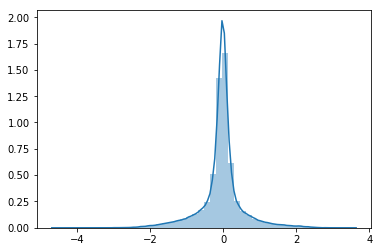

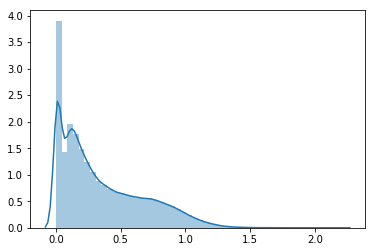

In [29]:
encoder_all = Model([x_t, x_lc,s], [z_mean, z_log_var], name="encoder")
z_aux, z_var_aux = encoder_all.predict([X_train_t,X_train, S_train], batch_size=512)

sns.distplot(z_aux.flatten())
plt.show()
sns.distplot(np.exp(z_var_aux.flatten()))
plt.show()

----- EVALUANDO RECONSTRUCCION DE LA CURVA -----


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


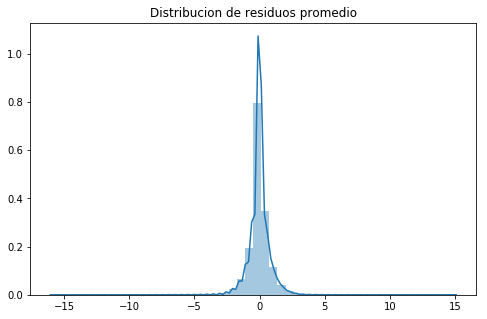

MSE      =  0.632405281536608
RMSE (+-)=  0.7692728846091076
MAE  (+-)=  0.4949288082892694
--------- Smoothness ------------
AutoCorr lag-one =  0.5796407883344092
Diff MEAN =  0.07470465173997198
Diff STD =  0.4045326795967392
--------- Smoothness ------------
MSE de escala escalado=  0.010310658399792871


array([[  853.6259],
       [21733.111 ],
       [84811.51  ],
       ...,
       [16374.502 ],
       [43017.367 ],
       [15769.644 ]], dtype=float32)

In [30]:
X_train_hat = vae.predict([X_train_t[:N], X_train[:N], S_train[:N]], batch_size=512)
evaluate_reconst(X_train[:N]*S_train[:N,None,:], X_train_hat*S_train[:N,None,:])

S_train_hat = s_model.predict([X_train_t[:N],X_train[:N], S_train[:N]], batch_size=512)
print("MSE de escala escalado= ",scaled_MSE((S_train[:N]-S_mu)/S_std, (S_train_hat-S_mu)/S_std,1 ))
S_train_hat

Real scale = 85.389943
Pred scale = 117.018822


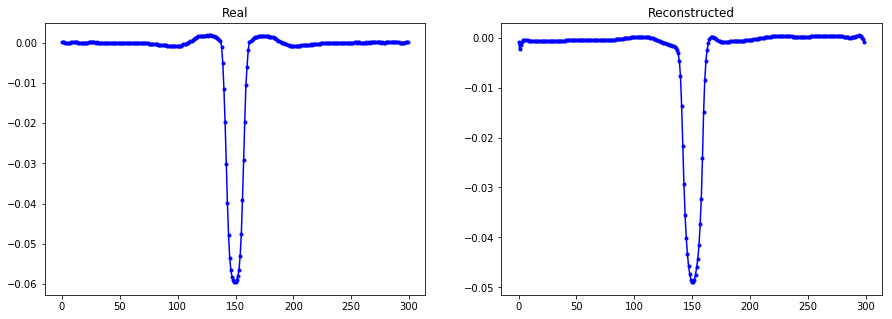

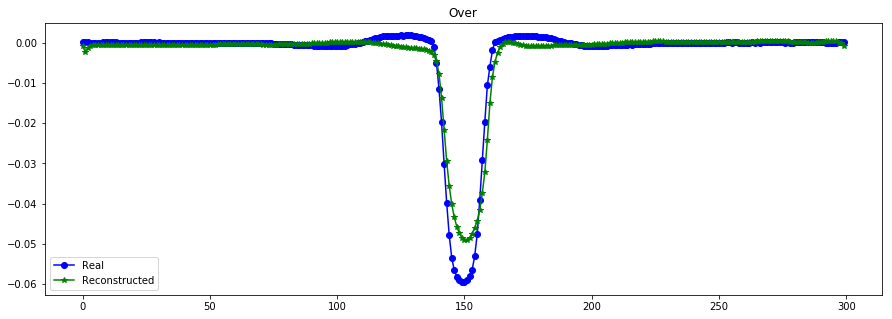

----------------------------------------------------------------
Real scale = 28766.629367
Pred scale = 29302.916016


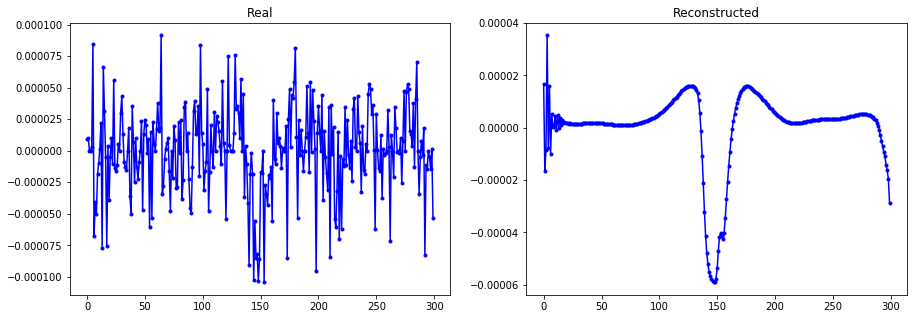

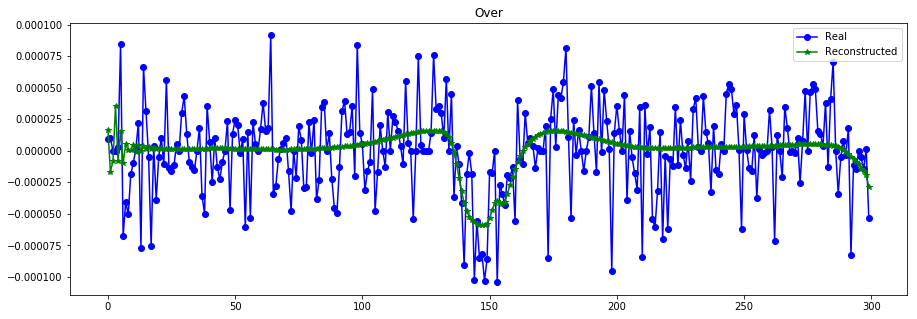

----------------------------------------------------------------
Real scale = 23631.225193
Pred scale = 23291.779297


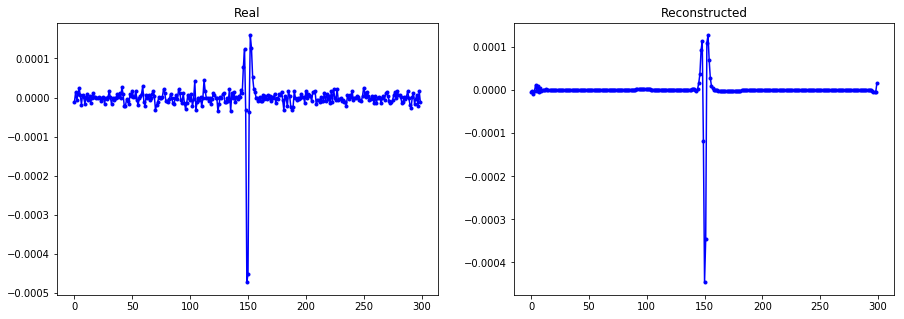

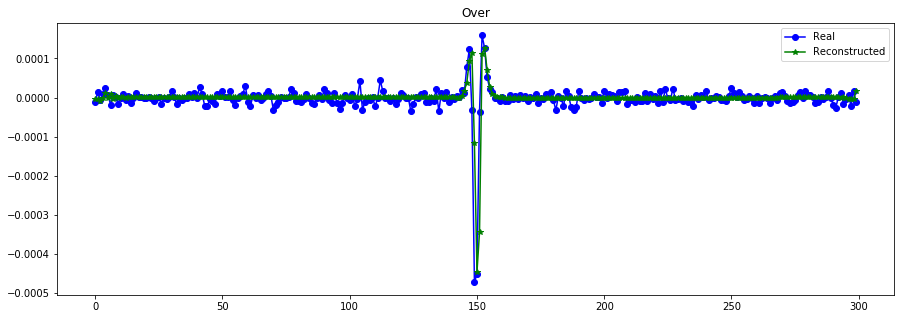

----------------------------------------------------------------
Real scale = 358653.137735
Pred scale = 352105.968750


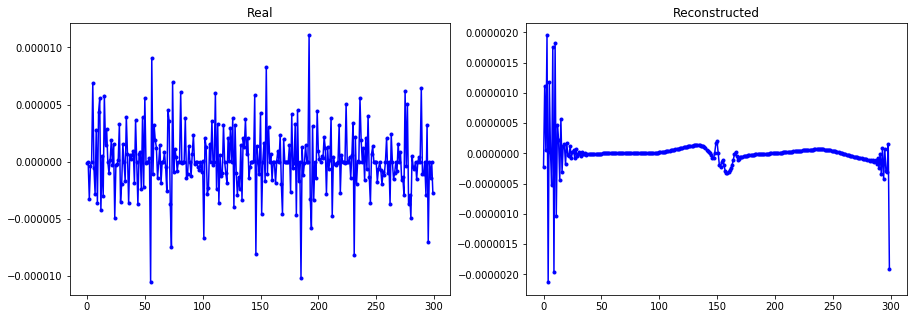

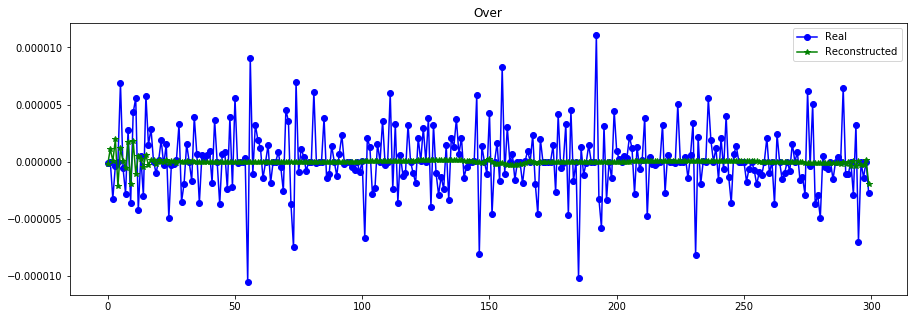

----------------------------------------------------------------
Real scale = 14935.862500
Pred scale = 15142.582031


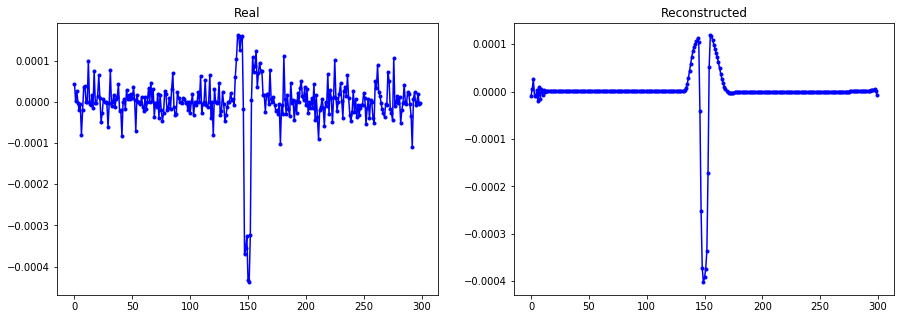

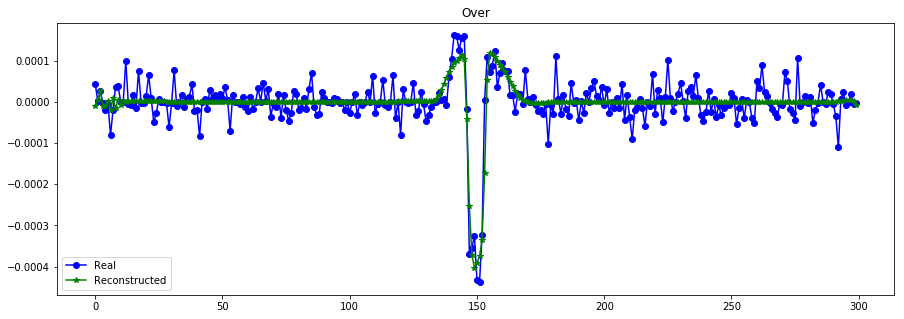

----------------------------------------------------------------
Real scale = 7645.135950
Pred scale = 7480.767578


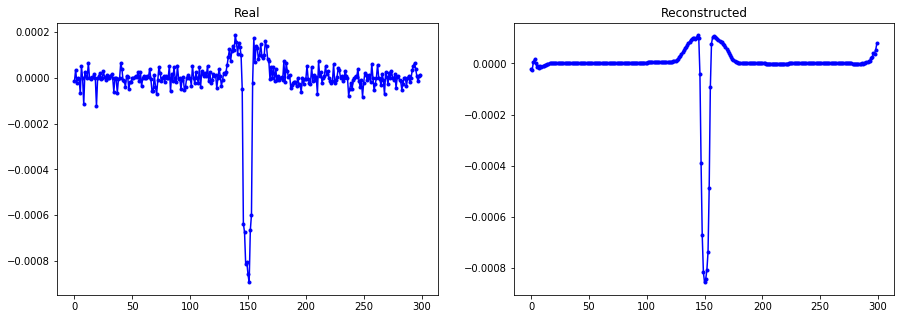

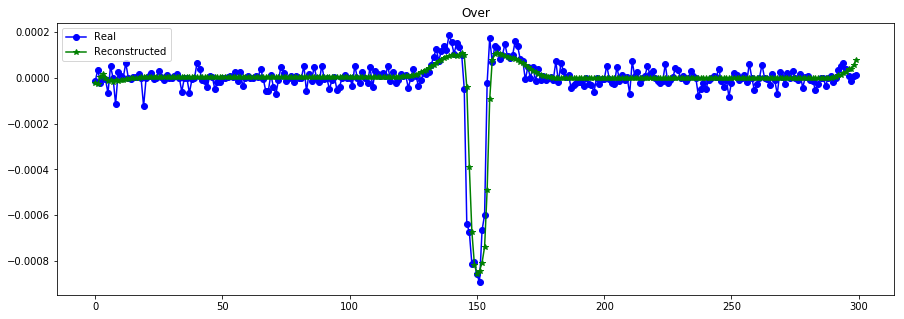

----------------------------------------------------------------
Real scale = 119642.152648
Pred scale = 112168.773438


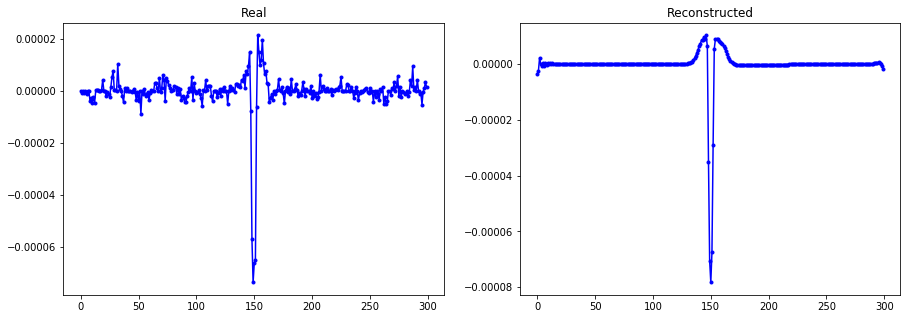

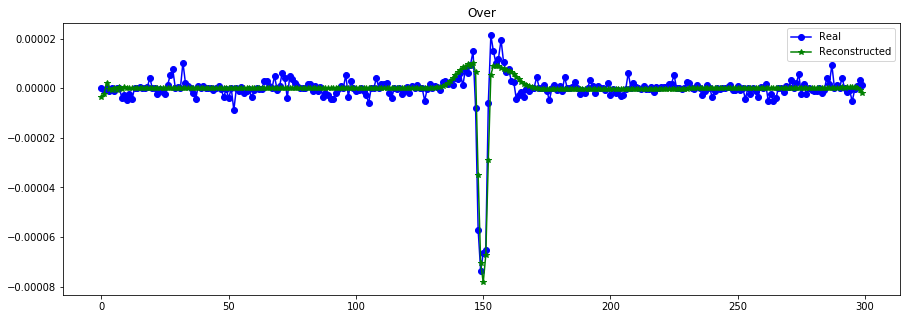

----------------------------------------------------------------
Real scale = 7477.545959
Pred scale = 8099.514648


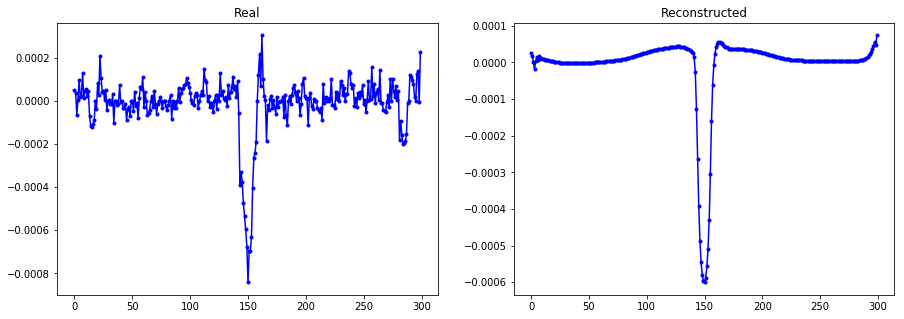

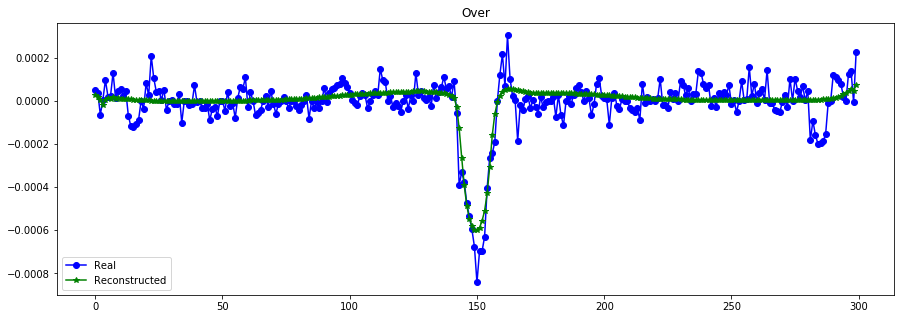

----------------------------------------------------------------
Real scale = 20231.807848
Pred scale = 19924.318359


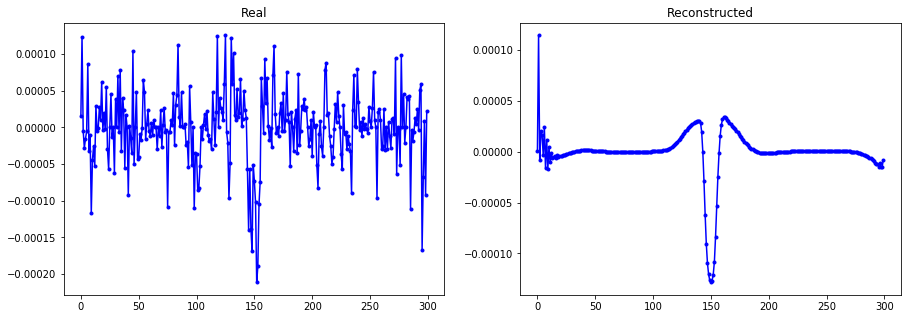

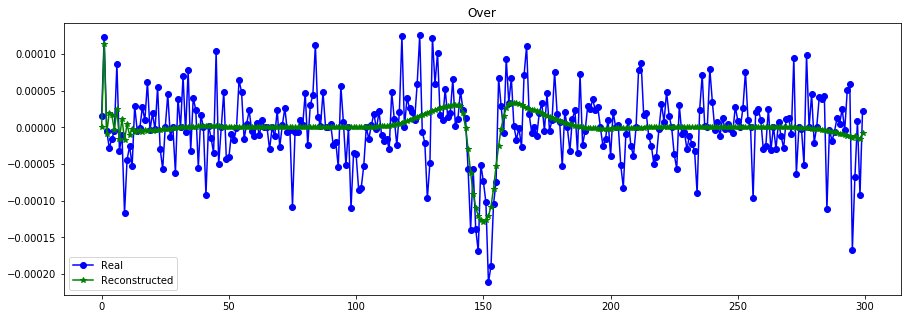

----------------------------------------------------------------
Real scale = 19613.881526
Pred scale = 20496.218750


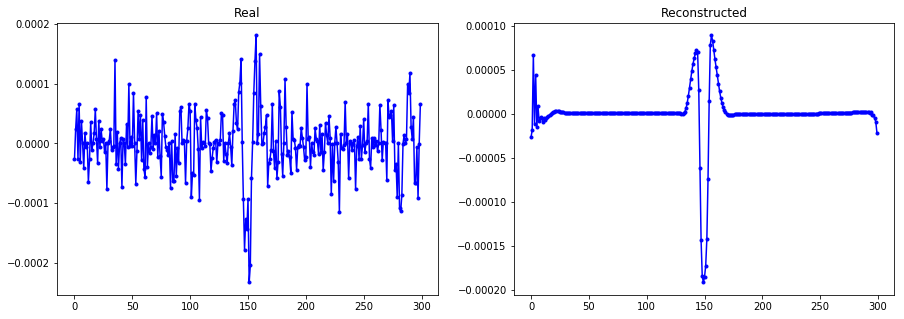

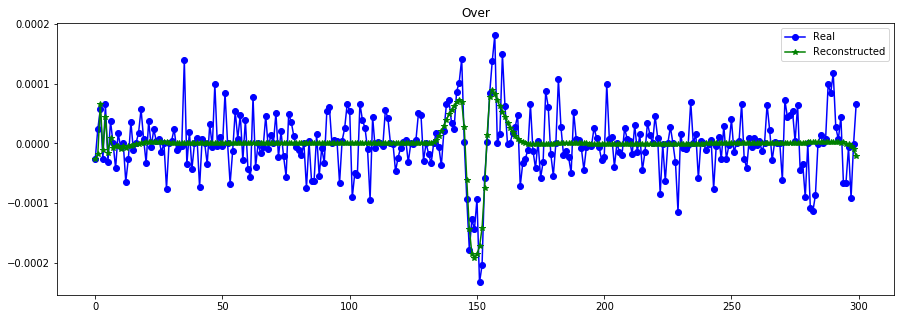

----------------------------------------------------------------
Real scale = 79164.558080
Pred scale = 80632.343750


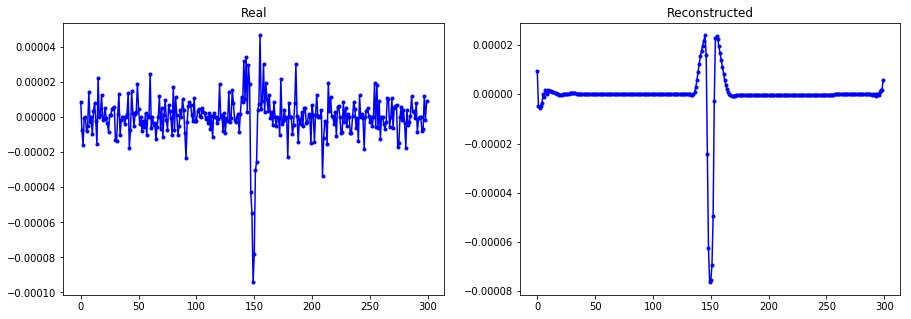

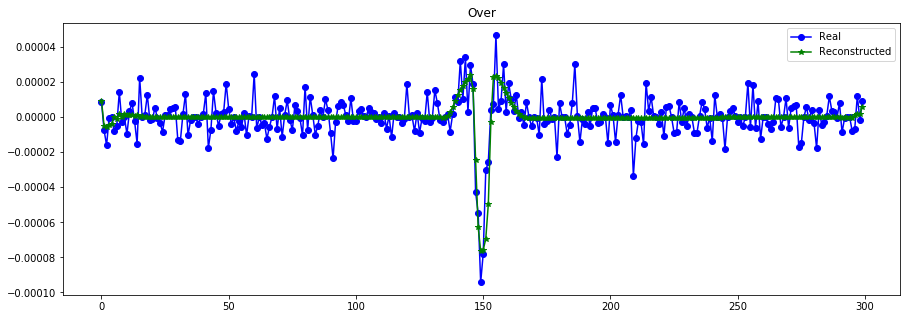

----------------------------------------------------------------
Real scale = 63420.227204
Pred scale = 64345.074219


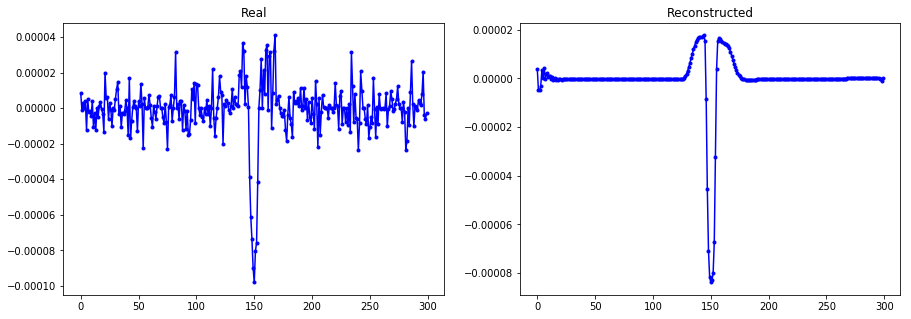

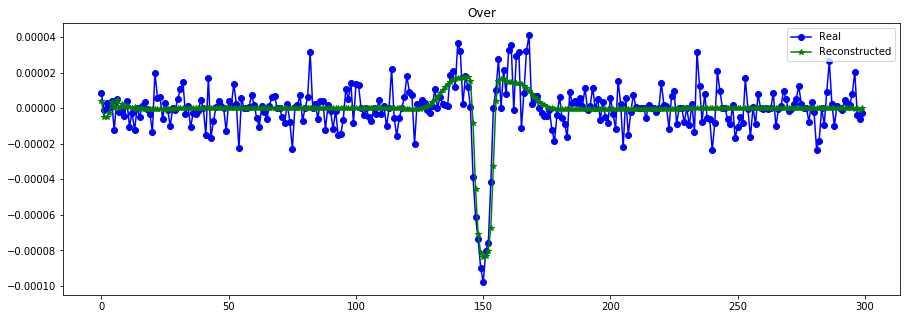

----------------------------------------------------------------
Real scale = 28339.445091
Pred scale = 28407.482422


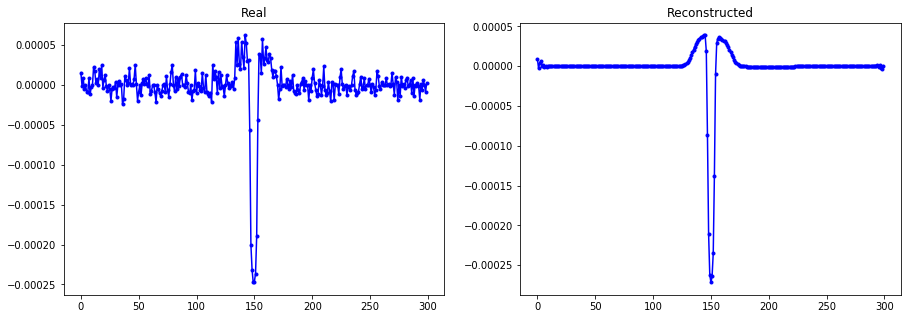

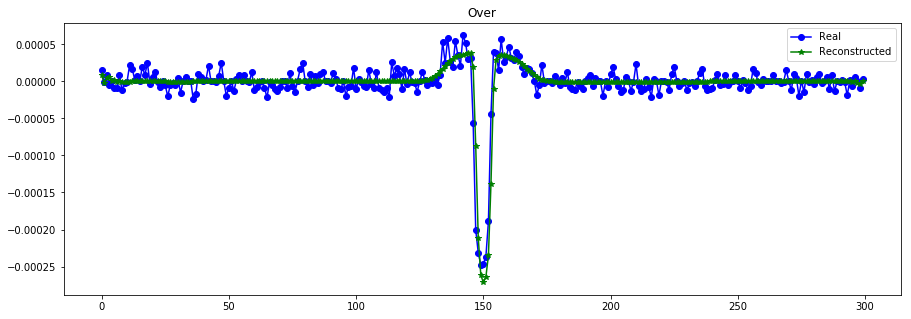

----------------------------------------------------------------
Real scale = 26016.586214
Pred scale = 26919.349609


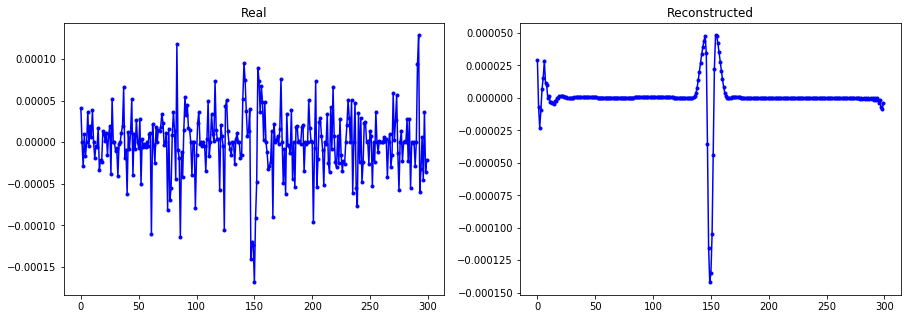

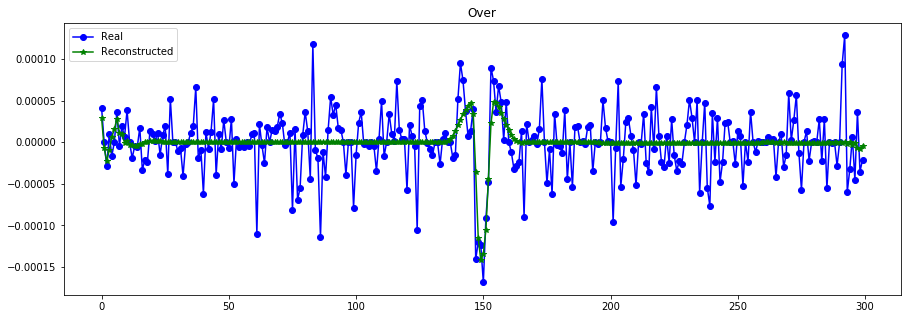

----------------------------------------------------------------
Real scale = 20413.081852
Pred scale = 19977.080078


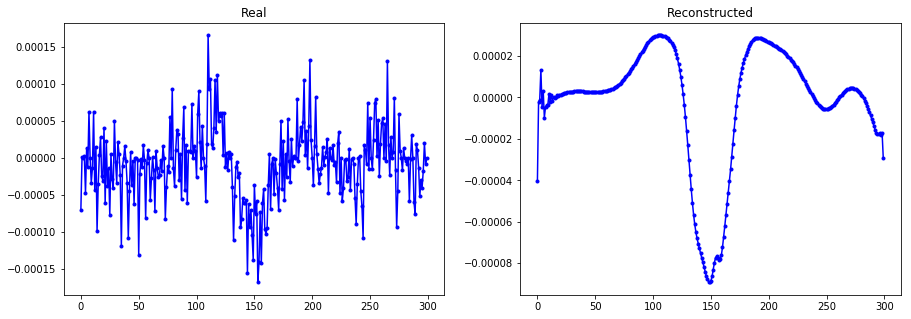

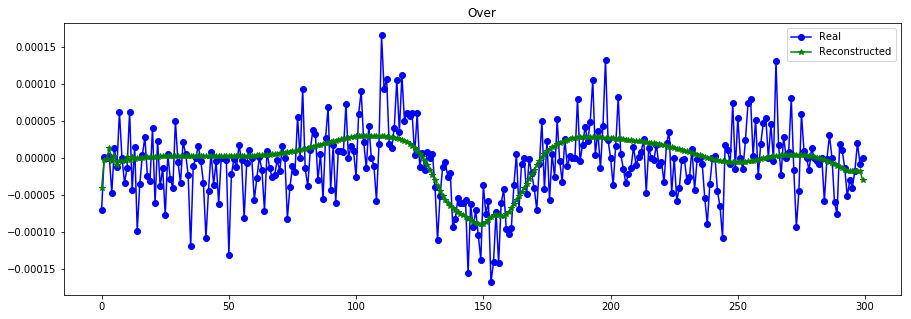

----------------------------------------------------------------


In [31]:
plot_n_lc(X_train[:N,:,0], X_train_hat, n= 15, s=[S_train[:N],S_train_hat]) #

In [32]:
vae.save_weights("./models/%dT_%dD_%de_VAE_scaleL.h5"%(T,latent_dim,400))

### con loss sobre escala mas bajo
hasta ahora el mejor:   

In [34]:
def Wvae_loss(y_true, y_pred):
    mse_LC = MSE_loss(y_true, y_pred)
    weights = K.square(s)[:,0]
    wmse_LC = mse_LC * weights #both values has to be on same shape
    
    mse_S = MSE_scale(y_true, y_pred)
    
    kl_loss = KL_loss(y_true, y_pred)
    
    return wmse_LC + l*kl_loss + 0.1*mse_S 

vae.compile(optimizer='adam', loss=Wvae_loss, metrics = [MSE_loss, KL_loss, MSE_scale])
batch_size = 64

hist = vae.fit([X_train_t, X_train, S_train], X_train, epochs=400, batch_size=batch_size)
        #validation_split=0.25) 

Epoch 1/400
8634/8634 [==============================] - 30s 3ms/step - loss: 2.5432 - MSE_loss: 1.3101e-07 - KL_loss: 3.0600 - MSE_scale: 4.7836
Epoch 2/400
8634/8634 [==============================] - 26s 3ms/step - loss: 1.5244 - MSE_loss: 1.3068e-07 - KL_loss: 29.5660 - MSE_scale: 4.1660
Epoch 3/400
8634/8634 [==============================] - 25s 3ms/step - loss: 1.2692 - MSE_loss: 1.3068e-07 - KL_loss: 36.3258 - MSE_scale: 2.1325
Epoch 4/400
8634/8634 [==============================] - 26s 3ms/step - loss: 1.2454 - MSE_loss: 1.3068e-07 - KL_loss: 28.4510 - MSE_scale: 2.0377
Epoch 5/400
8634/8634 [==============================] - 25s 3ms/step - loss: 1.2301 - MSE_loss: 1.3068e-07 - KL_loss: 22.6839 - MSE_scale: 1.9521
Epoch 6/400
8634/8634 [==============================] - 25s 3ms/step - loss: 1.1918 - MSE_loss: 1.3069e-07 - KL_loss: 17.2450 - MSE_scale: 1.5497
Epoch 7/400
8634/8634 [==============================] - 25s 3ms/step - loss: 1.1249 - MSE_loss: 1.3066e-07 - KL_loss: 

8634/8634 [==============================] - 26s 3ms/step - loss: 0.9223 - MSE_loss: 1.1156e-07 - KL_loss: 27.2821 - MSE_scale: 0.0786
Epoch 57/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.8724 - MSE_loss: 1.0795e-07 - KL_loss: 28.6278 - MSE_scale: 0.0683
Epoch 58/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.8899 - MSE_loss: 1.0483e-07 - KL_loss: 28.7996 - MSE_scale: 0.0687
Epoch 59/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.8576 - MSE_loss: 1.0379e-07 - KL_loss: 31.3276 - MSE_scale: 0.0671
Epoch 60/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.8651 - MSE_loss: 1.0134e-07 - KL_loss: 29.3516 - MSE_scale: 0.0682
Epoch 61/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.8755 - MSE_loss: 1.0234e-07 - KL_loss: 28.5169 - MSE_scale: 0.0764
Epoch 62/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.8642 - MSE_loss: 9.9766e-08 - KL_loss: 28.47

8634/8634 [==============================] - 25s 3ms/step - loss: 0.7552 - MSE_loss: 3.8219e-08 - KL_loss: 23.3256 - MSE_scale: 0.0189
Epoch 112/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7648 - MSE_loss: 3.7521e-08 - KL_loss: 22.8835 - MSE_scale: 0.0173
Epoch 113/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7722 - MSE_loss: 3.8394e-08 - KL_loss: 23.2086 - MSE_scale: 0.0187
Epoch 114/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7934 - MSE_loss: 4.4830e-08 - KL_loss: 21.7504 - MSE_scale: 0.0227
Epoch 115/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7809 - MSE_loss: 4.0147e-08 - KL_loss: 21.9698 - MSE_scale: 0.0171
Epoch 116/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7713 - MSE_loss: 4.2028e-08 - KL_loss: 22.5788 - MSE_scale: 0.0160
Epoch 117/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7624 - MSE_loss: 3.7877e-08 - KL_loss:

8634/8634 [==============================] - 25s 3ms/step - loss: 0.7500 - MSE_loss: 3.5422e-08 - KL_loss: 21.1223 - MSE_scale: 0.0147
Epoch 167/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7583 - MSE_loss: 3.3202e-08 - KL_loss: 20.2887 - MSE_scale: 0.0141
Epoch 168/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7396 - MSE_loss: 3.3005e-08 - KL_loss: 21.3253 - MSE_scale: 0.0136
Epoch 169/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7412 - MSE_loss: 3.3162e-08 - KL_loss: 20.2819 - MSE_scale: 0.0154
Epoch 170/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7484 - MSE_loss: 3.4871e-08 - KL_loss: 21.1377 - MSE_scale: 0.0138
Epoch 171/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7300 - MSE_loss: 3.0027e-08 - KL_loss: 21.4326 - MSE_scale: 0.0137
Epoch 172/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7443 - MSE_loss: 3.1399e-08 - KL_loss:

8634/8634 [==============================] - 26s 3ms/step - loss: 0.7203 - MSE_loss: 2.5829e-08 - KL_loss: 20.7755 - MSE_scale: 0.0117
Epoch 222/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7045 - MSE_loss: 2.4030e-08 - KL_loss: 20.8622 - MSE_scale: 0.0132
Epoch 223/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7193 - MSE_loss: 2.4318e-08 - KL_loss: 20.9125 - MSE_scale: 0.0118
Epoch 224/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7123 - MSE_loss: 2.5581e-08 - KL_loss: 21.1036 - MSE_scale: 0.0119
Epoch 225/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7169 - MSE_loss: 2.3640e-08 - KL_loss: 21.3232 - MSE_scale: 0.0117
Epoch 226/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7018 - MSE_loss: 2.2599e-08 - KL_loss: 21.1032 - MSE_scale: 0.0124
Epoch 227/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7356 - MSE_loss: 2.6758e-08 - KL_loss:

8634/8634 [==============================] - 25s 3ms/step - loss: 0.7143 - MSE_loss: 2.1914e-08 - KL_loss: 20.6454 - MSE_scale: 0.0130
Epoch 277/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7023 - MSE_loss: 2.4069e-08 - KL_loss: 20.5851 - MSE_scale: 0.0127
Epoch 278/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7058 - MSE_loss: 1.9858e-08 - KL_loss: 20.2251 - MSE_scale: 0.0114
Epoch 279/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6885 - MSE_loss: 2.2019e-08 - KL_loss: 20.8313 - MSE_scale: 0.0123
Epoch 280/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.6964 - MSE_loss: 1.9445e-08 - KL_loss: 20.9607 - MSE_scale: 0.0116
Epoch 281/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.7012 - MSE_loss: 2.2697e-08 - KL_loss: 20.6599 - MSE_scale: 0.0126
Epoch 282/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7186 - MSE_loss: 2.2517e-08 - KL_loss:

8634/8634 [==============================] - 25s 3ms/step - loss: 0.6823 - MSE_loss: 1.9134e-08 - KL_loss: 21.9008 - MSE_scale: 0.0146
Epoch 332/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.6798 - MSE_loss: 1.7134e-08 - KL_loss: 21.8402 - MSE_scale: 0.0148
Epoch 333/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6727 - MSE_loss: 1.8815e-08 - KL_loss: 22.1202 - MSE_scale: 0.0142
Epoch 334/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6777 - MSE_loss: 1.7050e-08 - KL_loss: 22.0471 - MSE_scale: 0.0150
Epoch 335/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.6772 - MSE_loss: 2.0283e-08 - KL_loss: 21.8814 - MSE_scale: 0.0147
Epoch 336/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.6755 - MSE_loss: 1.9105e-08 - KL_loss: 22.1291 - MSE_scale: 0.0129
Epoch 337/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6977 - MSE_loss: 1.7838e-08 - KL_loss:

8634/8634 [==============================] - 26s 3ms/step - loss: 0.6495 - MSE_loss: 1.5537e-08 - KL_loss: 22.4526 - MSE_scale: 0.0130
Epoch 387/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.6612 - MSE_loss: 1.8971e-08 - KL_loss: 22.5401 - MSE_scale: 0.0121
Epoch 388/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.6387 - MSE_loss: 1.6619e-08 - KL_loss: 22.4167 - MSE_scale: 0.0112
Epoch 389/400
8634/8634 [==============================] - 25s 3ms/step - loss: 0.6538 - MSE_loss: 1.6253e-08 - KL_loss: 22.3071 - MSE_scale: 0.0115
Epoch 390/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6466 - MSE_loss: 1.3530e-08 - KL_loss: 22.6388 - MSE_scale: 0.0121
Epoch 391/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6677 - MSE_loss: 1.8775e-08 - KL_loss: 22.1959 - MSE_scale: 0.0133
Epoch 392/400
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6662 - MSE_loss: 1.9139e-08 - KL_loss:

In [24]:
vae.load_weights("./models/%dT_%dD_%de_VAE_scaleLlow.h5"%(T,latent_dim,400))

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


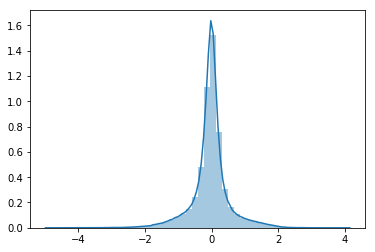

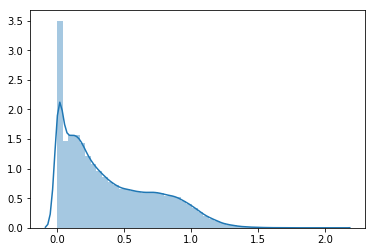

In [29]:
encoder_all = Model([x_t, x_lc,s], [z_mean, z_log_var], name="encoder")
z_aux, z_var_aux = encoder_all.predict([X_train_t,X_train, S_train], batch_size=512)

sns.distplot(z_aux.flatten())
plt.show()
sns.distplot(np.exp(z_var_aux.flatten()))
plt.show()

----- EVALUANDO RECONSTRUCCION DE LA CURVA -----


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


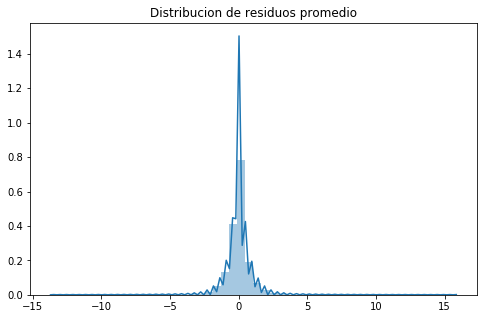

MSE      =  0.5361171411706324
RMSE (+-)=  0.6898552534553549
MAE  (+-)=  0.4815358910187573
--------- Smoothness ------------
AutoCorr lag-one =  0.5786424844267111
Diff MEAN =  0.06860946405409063
Diff STD =  0.3988897587281383
--------- Smoothness ------------
MSE de escala escalado=  0.04311562832221648


array([[  770.5652],
       [24008.393 ],
       [77057.336 ],
       ...,
       [15770.981 ],
       [49347.695 ],
       [16727.49  ]], dtype=float32)

In [36]:
X_train_hat = vae.predict([X_train_t[:N], X_train[:N], S_train[:N]], batch_size=512)
evaluate_reconst(X_train[:N]*S_train[:N,None,:], X_train_hat*S_train[:N,None,:])

S_train_hat = s_model.predict([X_train_t[:N],X_train[:N], S_train[:N]], batch_size=512)
print("MSE de escala escalado= ",scaled_MSE((S_train[:N]-S_mu)/S_std, (S_train_hat-S_mu)/S_std,1 ))
S_train_hat

Real scale = 10449.540787
Pred scale = 11602.317383


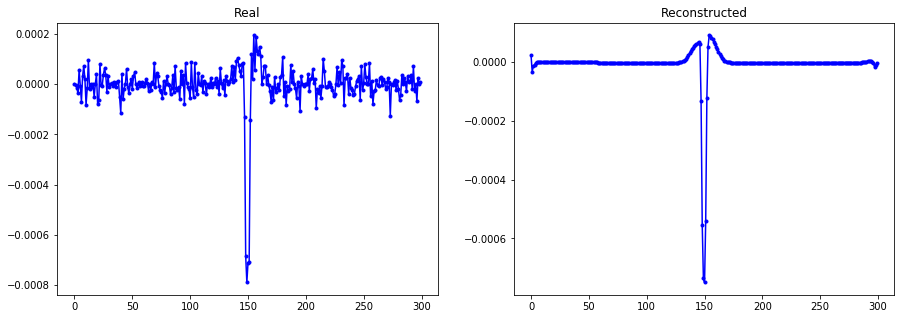

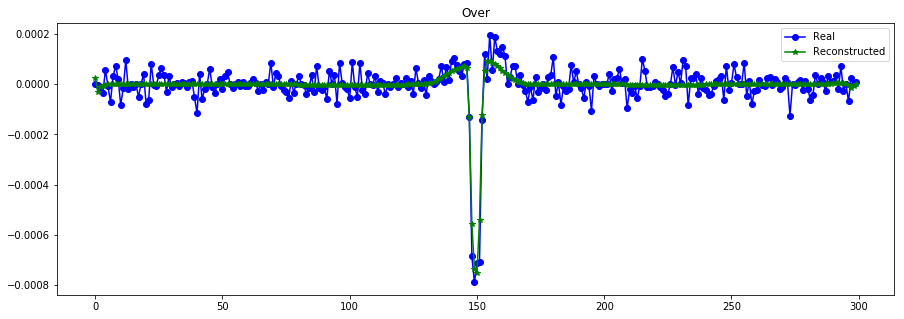

----------------------------------------------------------------
Real scale = 45957.493340
Pred scale = 38550.628906


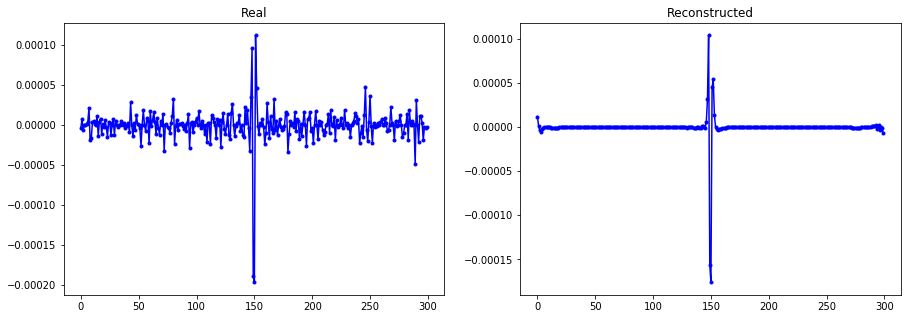

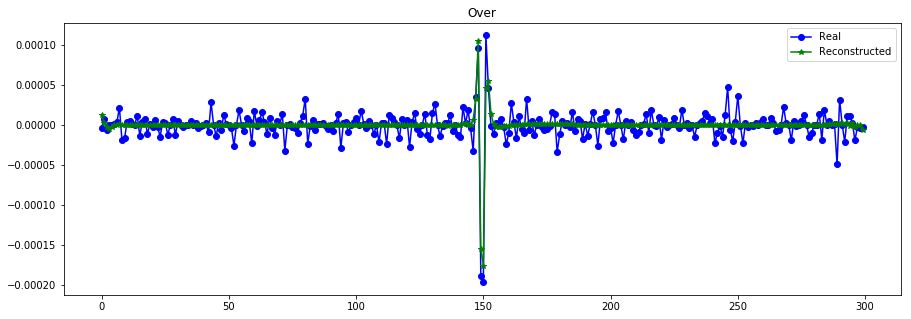

----------------------------------------------------------------
Real scale = 248843.163746
Pred scale = 193343.578125


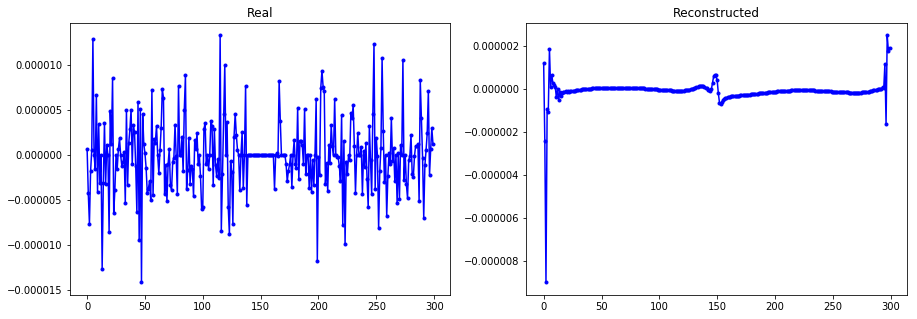

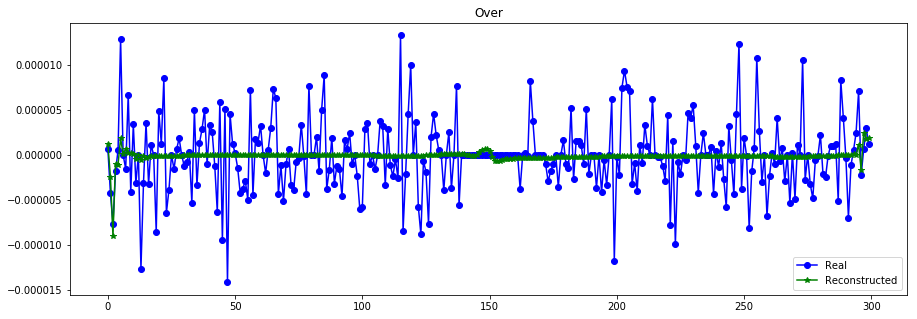

----------------------------------------------------------------
Real scale = 39603.458704
Pred scale = 40947.562500


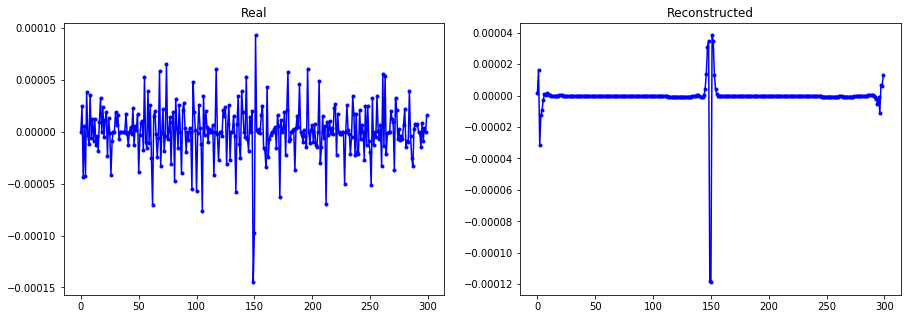

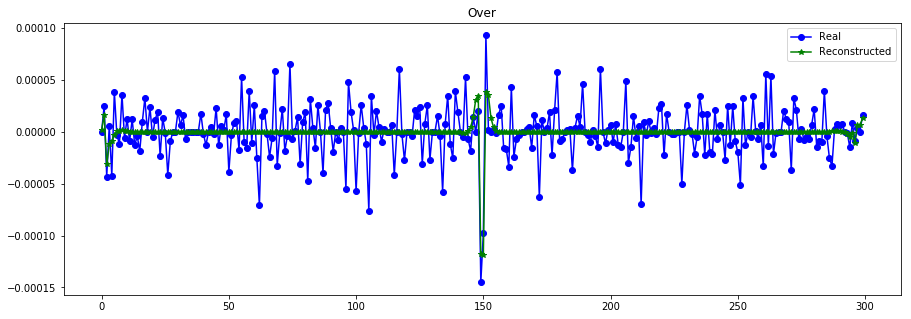

----------------------------------------------------------------
Real scale = 27222.066137
Pred scale = 29911.886719


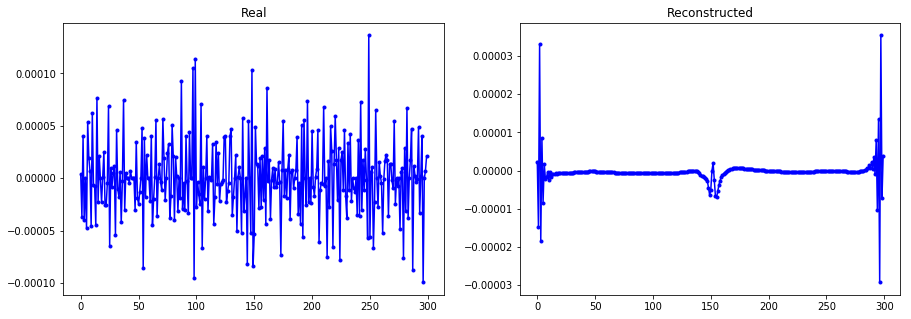

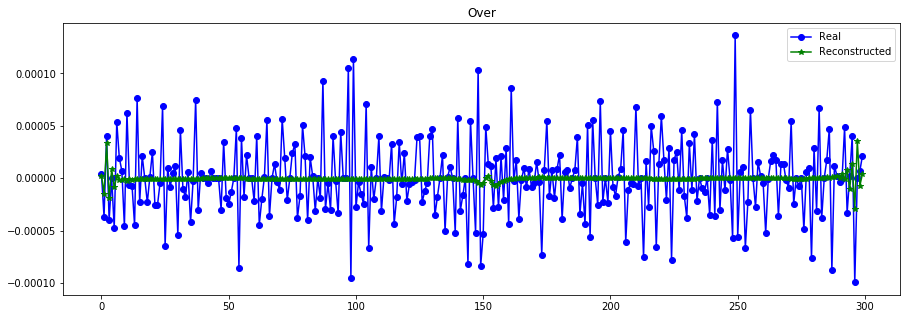

----------------------------------------------------------------
Real scale = 10125.437116
Pred scale = 10019.332031


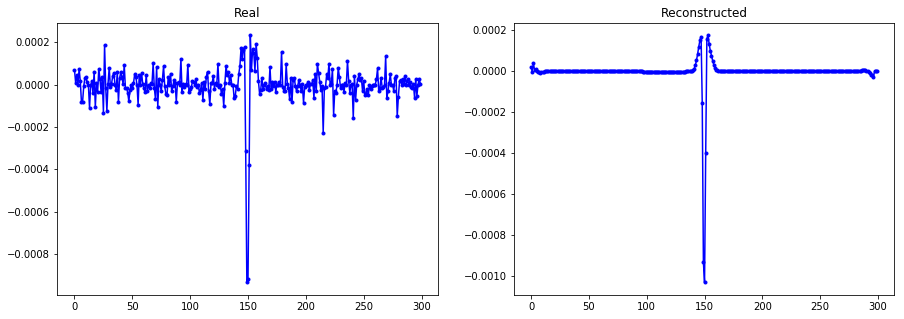

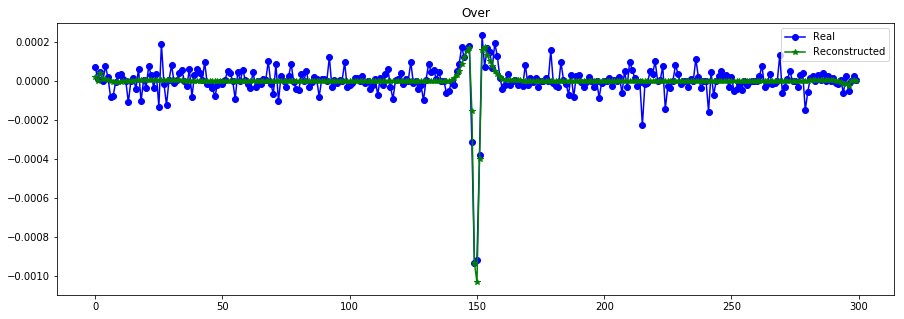

----------------------------------------------------------------
Real scale = 26255.948927
Pred scale = 25516.009766


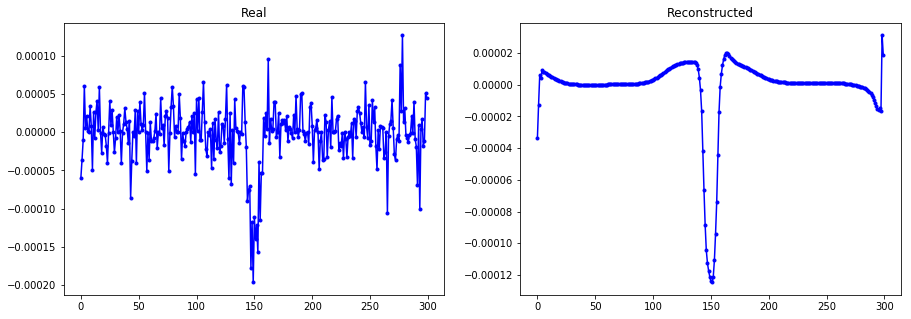

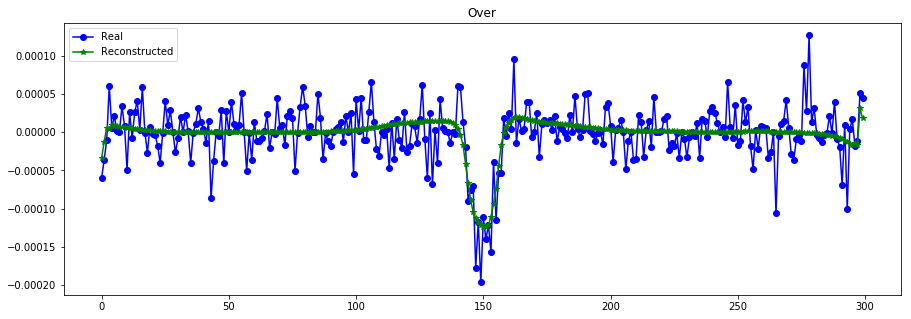

----------------------------------------------------------------
Real scale = 47154.934927
Pred scale = 43595.230469


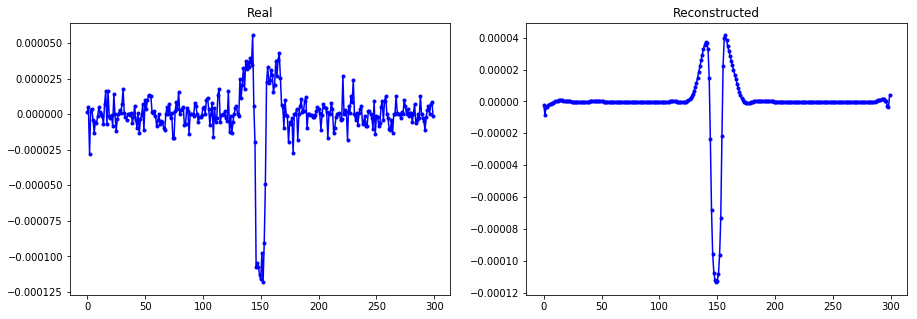

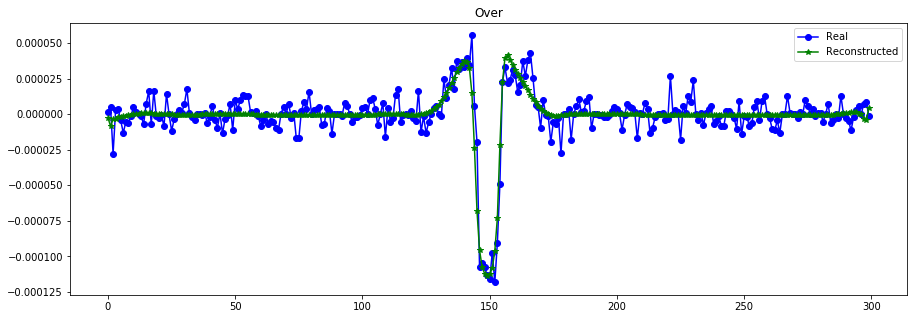

----------------------------------------------------------------
Real scale = 208056.285146
Pred scale = 229487.343750


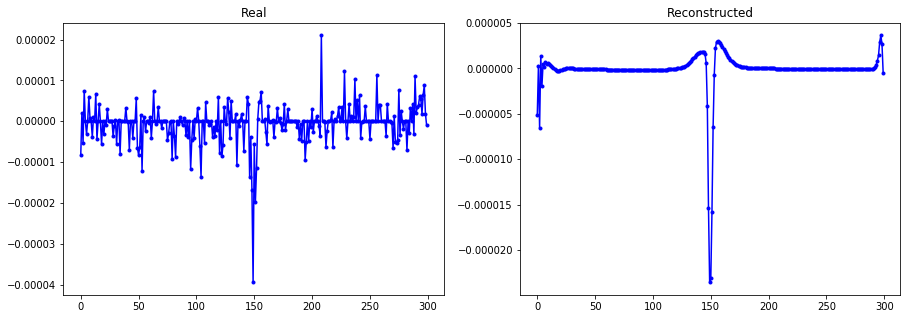

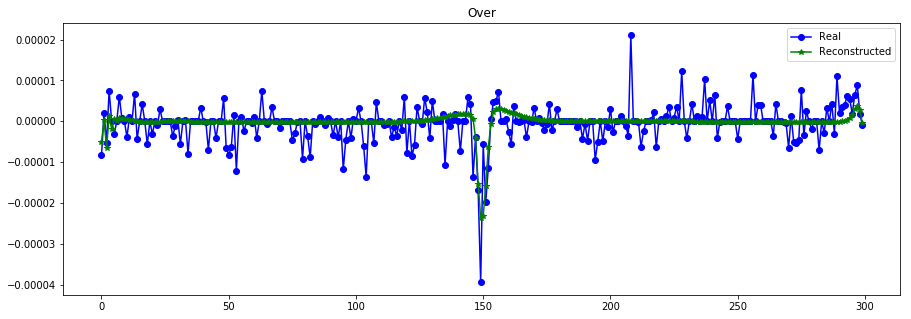

----------------------------------------------------------------
Real scale = 48419.659020
Pred scale = 50269.765625


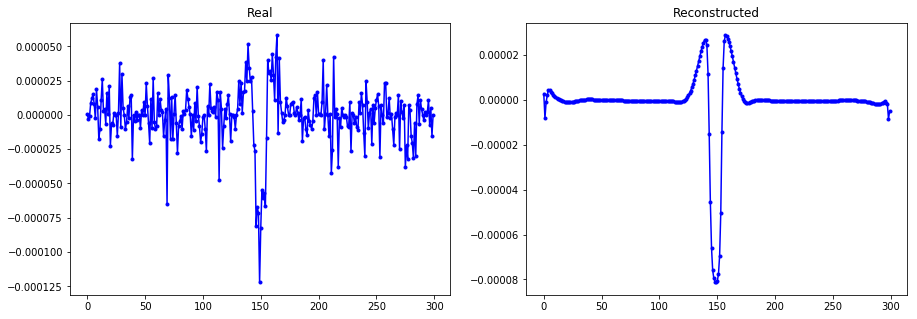

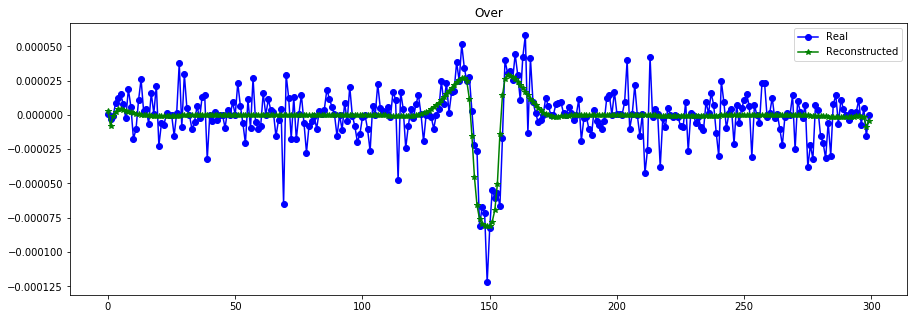

----------------------------------------------------------------
Real scale = 37167.459855
Pred scale = 38598.855469


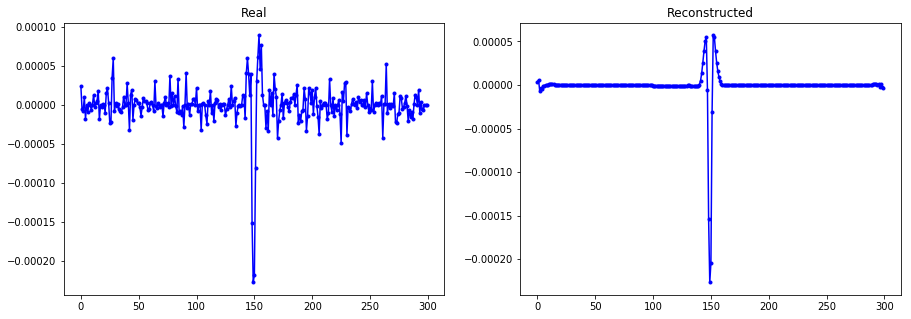

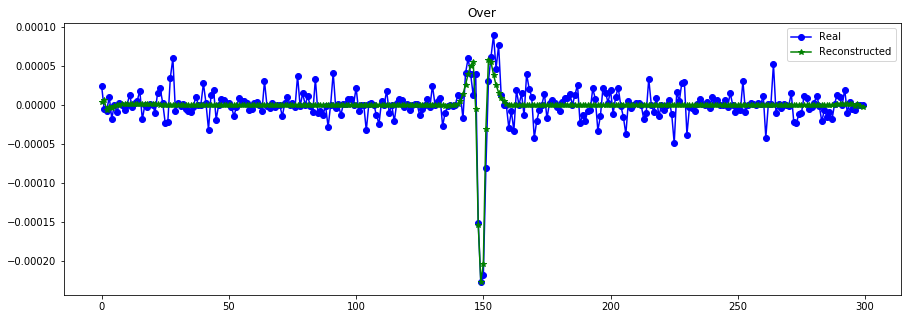

----------------------------------------------------------------
Real scale = 34870.618068
Pred scale = 34061.390625


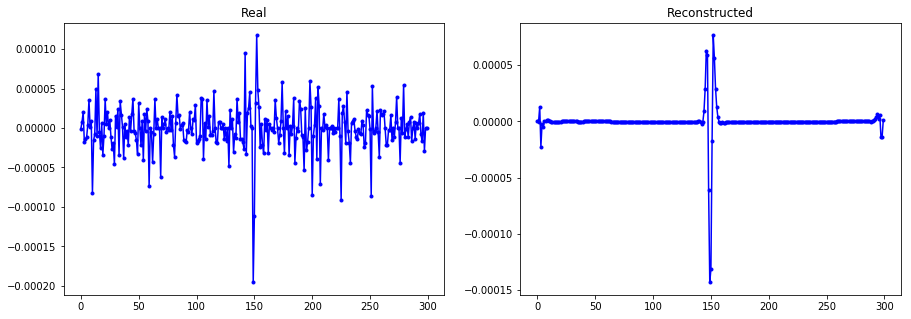

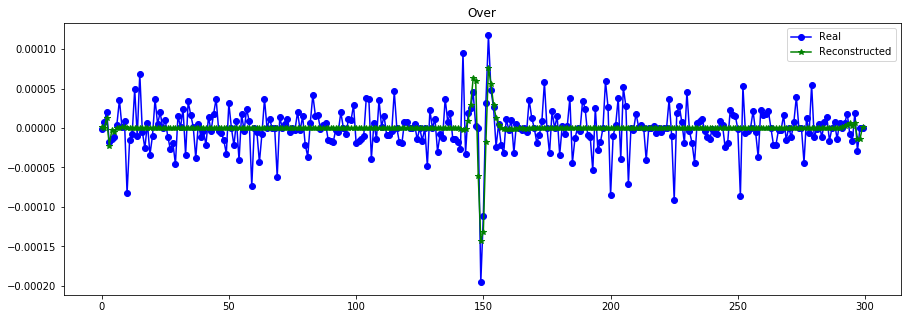

----------------------------------------------------------------
Real scale = 34406.690354
Pred scale = 39084.660156


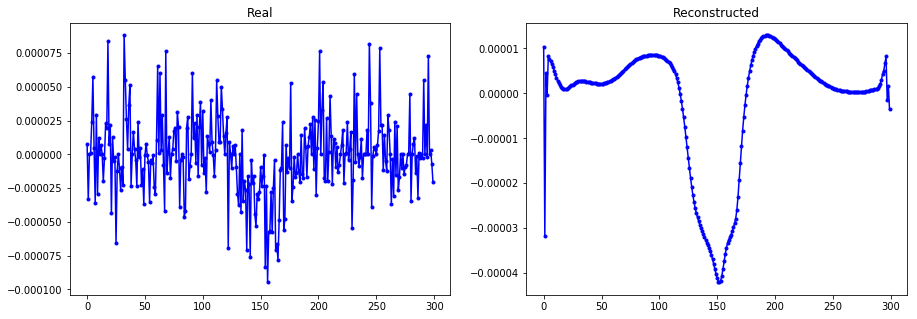

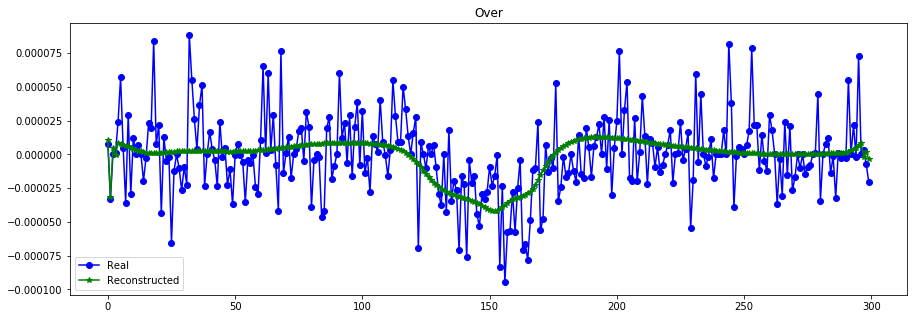

----------------------------------------------------------------
Real scale = 185712.002030
Pred scale = 199542.218750


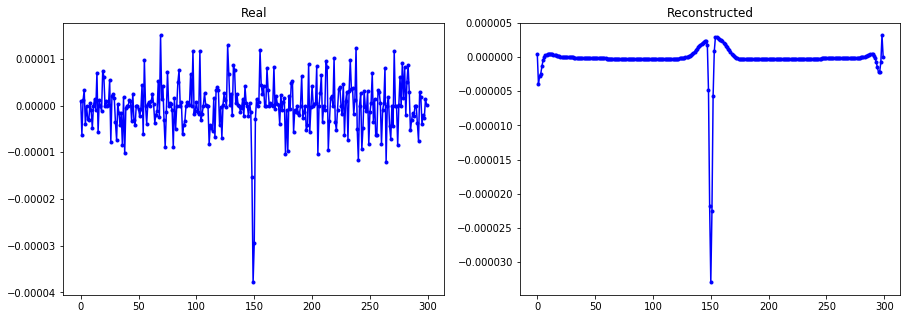

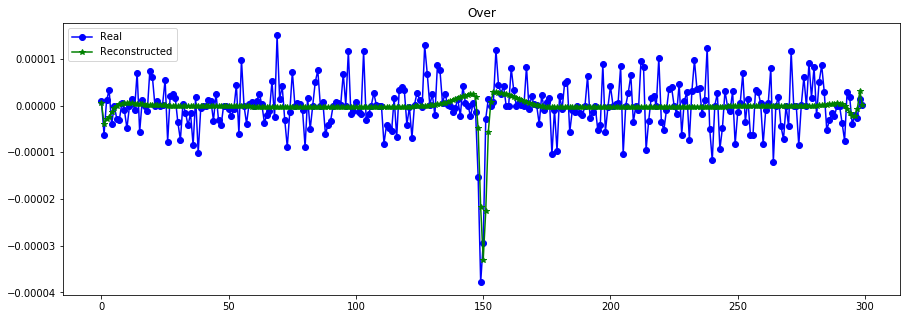

----------------------------------------------------------------
Real scale = 20069.666236
Pred scale = 24859.316406


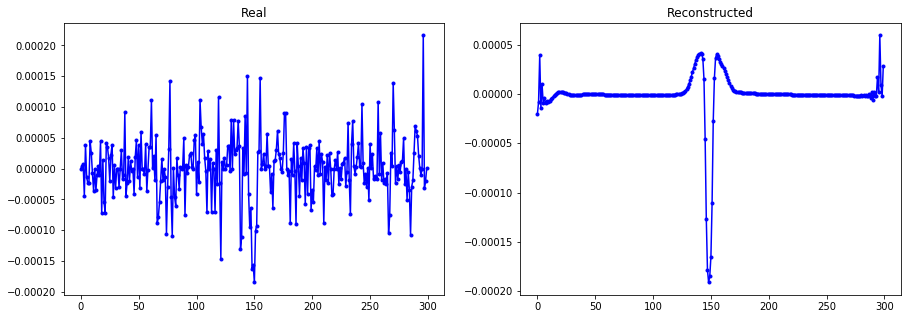

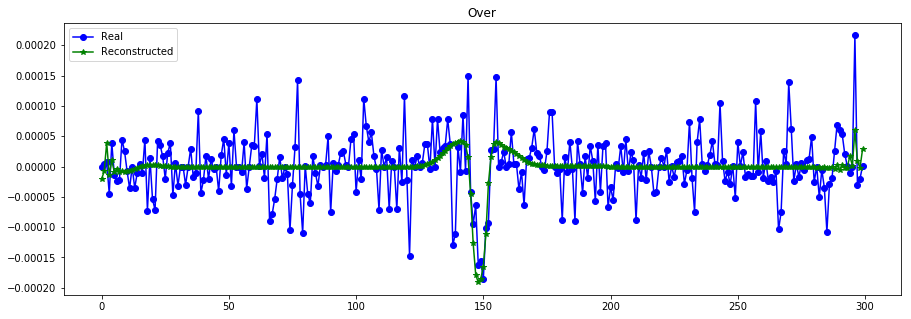

----------------------------------------------------------------


In [37]:
plot_n_lc(X_train[:N,:,0], X_train_hat, n= 15, s=[S_train[:N],S_train_hat]) #

In [21]:
vae.save_weights("./models/%dT_%dD_%de_VAE_scaleLlow.h5"%(T,latent_dim,400))

In [ ]:
# al optimizar kL tambien al modelo le cuesta ajustar los pics.. (los valores minimos) en especial cuando son pocos..

### Vizualize encoded

In [30]:
def transform_plot(model, data, just_plot=False):
    if just_plot:
        to_plot = data
    else:
        to_plot = model.fit_transform(data)
        
    plt.figure(figsize=(10,7))
    plt.scatter(to_plot[:,0],to_plot[:,1])
    plt.show()
    return to_plot

Y_transit = df_meta_obj.values[mask_transit]
labels_transit = df_meta["NExScI Disposition"].values[mask_transit]

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


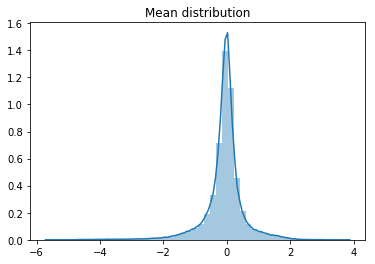

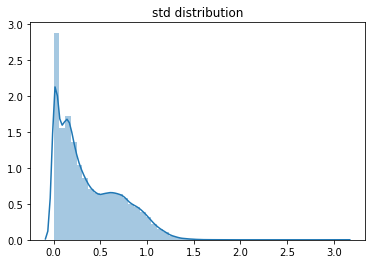

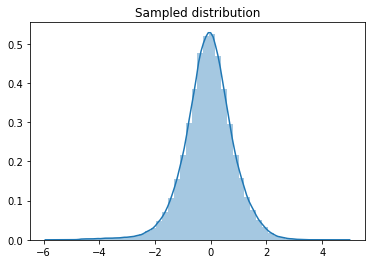

In [31]:
encoder_all = Model([x_t, x_lc,s], [z_mean, z_log_var], name="encoder")
z_aux, z_var_aux = encoder_all.predict([X_train_t_all,X_train_all, S_train_all], batch_size=512)
z_samp = samp_encoder.predict([X_train_t_all, X_train_all, S_train_all], batch_size=512)

sns.distplot(z_aux.flatten())
plt.title("Mean distribution")
plt.show()

sns.distplot(np.exp(z_var_aux.flatten()))
plt.title("std distribution")
plt.show()

sns.distplot(z_samp.flatten())
plt.title("Sampled distribution")
plt.show()

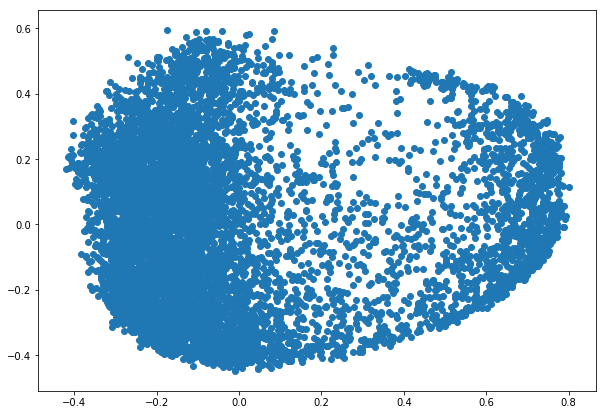

In [32]:
from sklearn.decomposition import KernelPCA
model = KernelPCA(2, kernel='rbf', gamma=None, n_jobs=-1)
    
to_plot = transform_plot(model, z_aux)

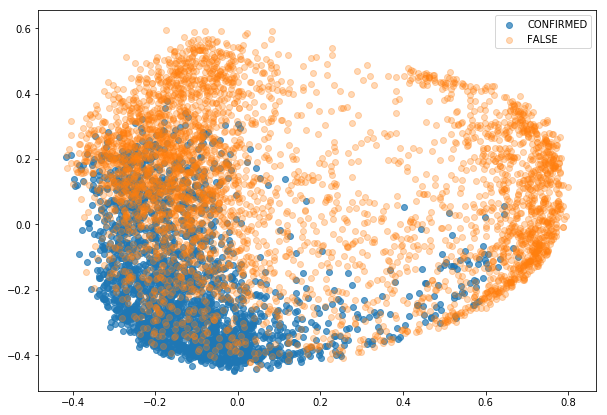

In [33]:
plt.figure(figsize=(10,7))
mask_ = (all_labels=="CONFIRMED")
plt.scatter(to_plot[:,0][mask_],to_plot[:,1][mask_], label="CONFIRMED", alpha=0.7)

mask_ = (all_labels=="FALSE POSITIVE")
plt.scatter(to_plot[:,0][mask_],to_plot[:,1][mask_], label="FALSE", alpha=0.3)

plt.legend()
plt.show()

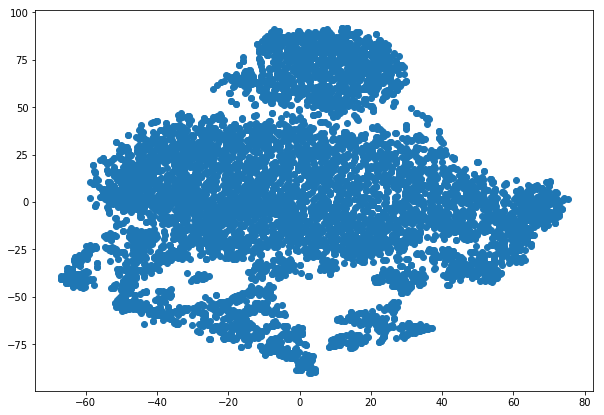

In [34]:
#tsne
from sklearn.manifold import TSNE
model = TSNE(2, metric='euclidean', n_jobs=-1)

to_plot = transform_plot(model, z_aux)

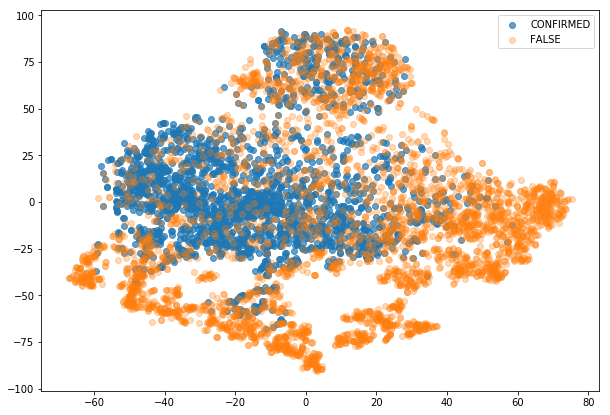

In [35]:
plt.figure(figsize=(10,7))
mask_ = (all_labels=="CONFIRMED")
plt.scatter(to_plot[:,0][mask_],to_plot[:,1][mask_], label="CONFIRMED", alpha=0.7)

mask_ = (all_labels=="FALSE POSITIVE")
plt.scatter(to_plot[:,0][mask_],to_plot[:,1][mask_], label="FALSE", alpha=0.3)

plt.legend()
plt.show()

In [36]:
np.save("./LC_features/VAE_scale_%dT_%dD.npy"%(T,latent_dim), z_aux)
np.save("./LC_features/VAE_scale_%dT_%dD_samp.npy"%(T,latent_dim), z_samp)
!ls ./LC_features

AE_300T_32D.npy		   MetadataLC.npy
FourierICA_300T_32D.npy    VAE_300T_32D.npy
FourierICA_71427T_32D.npy  VAE_300T_32D_samp.npy
FourierPCA_300T_32D.npy    VAE_scale_300T_32D.npy
FourierPCA_71427T_32D.npy  VAE_scale_300T_32D_samp.npy
